# Austin Housing Analysis: Time Series Forecasting

## 1. Overview

## 2. Business Problem

In [1]:
# Loading in Relevant Libraries:
import pandas as pd
import numpy as np
import pandas.tseries
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from pyzipcode import ZipCodeDatabase

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose


import pmdarima as pm
from pmdarima import model_selection
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose

from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [2]:
!ls Data

austin_area_zip_codes.geojson
zillow_data.csv


## 3. Data Understanding

This data comes from Zillow Housing Database.

In [3]:
# Read the dataset
data = pd.read_csv('Data/zillow_data.csv')
data

RegionID  RegionName                 City State              Metro  \
0         84654       60657              Chicago    IL            Chicago   
1         90668       75070             McKinney    TX  Dallas-Fort Worth   
2         91982       77494                 Katy    TX            Houston   
3         84616       60614              Chicago    IL            Chicago   
4         93144       79936              El Paso    TX            El Paso   
...         ...         ...                  ...   ...                ...   
14718     58333        1338             Ashfield    MA    Greenfield Town   
14719     59107        3293            Woodstock    NH          Claremont   
14720     75672       40404                Berea    KY           Richmond   
14721     93733       81225  Mount Crested Butte    CO                NaN   
14722     95851       89155             Mesquite    NV          Las Vegas   

      CountyName  SizeRank   1996-04   1996-05   1996-06  ...  2017-07  \
0           Cook         1  334200.0  335400.0  336500.0  ...  1005500   
1         Collin         2  235700.0  236900.0  236700.0  ...   308000   
2         Harris         3  210400.0  212200.0  212200.0  ...   321000   
3           Cook         4  498100.0  500900.0  503100.0  ...  1289800   
4        El Paso         5   77300.0   77300.0   77300.0  ...   119100   
...          ...       ...       ...       ...       ...  ...      ...   
14718   Franklin     14719   94600.0   94300.0   94000.0  ...   216800   
14719    Grafton     14720   92700.0   92500.0   92400.0  ...   202100   
14720    Madison     14721   57100.0   57300.0   57500.0  ...   121800   
14721   Gunnison     14722  191100.0  192400.0  193700.0  ...   662800   
14722      Clark     14723  176400.0  176300.0  176100.0  ...   333800   

       2017-08  2017-09  2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  \
0      1007500  1007800  1009600  1013300  1018700  1024400  1030700  1033800   
1       310000   312500   314100   315000   316600   318100   319600   321100   
2       320600   320200   320400   320800   321200   321200   323000   326900   
3      1287700  1287400  1291500  1296600  1299000  1302700  1306400  1308500   
4       119400   120000   120300   120300   120300   120300   120500   121000   
...        ...      ...      ...      ...      ...      ...      ...      ...   
14718   217700   218600   218500   218100   216400   213100   209800   209200   
14719   208400   212200   215200   214300   213100   213700   218300   222700   
14720   122800   124600   126700   128800   130600   131700   132500   133000   
14721   671200   682400   695600   695500   694700   706400   705300   681500   
14722   336400   339700   343800   346800   348900   350400   353000   356000   

       2018-04  
0      1030600  
1       321800  
2       329900  
3      1307000  
4       121500  
...        ...  
14718   209300  
14719   225800  
14720   133400  
14721   664400  
14722   357200  

[14723 rows x 272 columns]

In [4]:
# Look into Texas state:
texas_data= data[data['State'] == 'TX']
texas_data

RegionID  RegionName           City State              Metro  \
1         90668       75070       McKinney    TX  Dallas-Fort Worth   
2         91982       77494           Katy    TX            Houston   
4         93144       79936        El Paso    TX            El Paso   
5         91733       77084        Houston    TX            Houston   
8         91940       77449           Katy    TX            Houston   
...         ...         ...            ...   ...                ...   
14372     91640       76941        Mertzon    TX         San Angelo   
14472     92897       79313          Anton    TX          Levelland   
14492     92921       79355         Plains    TX                NaN   
14599     92929       79366  Ransom Canyon    TX            Lubbock   
14695     91948       77457      Matagorda    TX           Bay City   

      CountyName  SizeRank   1996-04   1996-05   1996-06  ...  2017-07  \
1         Collin         2  235700.0  236900.0  236700.0  ...   308000   
2         Harris         3  210400.0  212200.0  212200.0  ...   321000   
4        El Paso         5   77300.0   77300.0   77300.0  ...   119100   
5         Harris         6   95000.0   95200.0   95400.0  ...   157900   
8         Harris         9   95400.0   95600.0   95800.0  ...   166800   
...          ...       ...       ...       ...       ...  ...      ...   
14372      Irion     14373       NaN       NaN       NaN  ...   122500   
14472    Hockley     14473       NaN       NaN       NaN  ...    55400   
14492     Yoakum     14493       NaN       NaN       NaN  ...   100500   
14599    Lubbock     14600  134500.0  134500.0  134400.0  ...   252100   
14695  Matagorda     14696   90700.0   91000.0   91200.0  ...   250400   

       2017-08  2017-09  2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  \
1       310000   312500   314100   315000   316600   318100   319600   321100   
2       320600   320200   320400   320800   321200   321200   323000   326900   
4       119400   120000   120300   120300   120300   120300   120500   121000   
5       158700   160200   161900   162800   162800   162800   162900   163500   
8       167400   168400   169600   170900   172300   173300   174200   175400   
...        ...      ...      ...      ...      ...      ...      ...      ...   
14372   121800   121600   122200   123500   124700   124300   122600   121600   
14472    56300    55700    56300    58900    61500    63000    63600    63500   
14492   100500   101000   100700    99700    97700    95800    94600    94000   
14599   251600   251600   251500   251300   251500   251700   252500   255000   
14695   253300   256900   256100   250700   243200   238300   234200   230500   

       2018-04  
1       321800  
2       329900  
4       121500  
5       164300  
8       176200  
...        ...  
14372   121600  
14472    63300  
14492    93500  
14599   257500  
14695   227300  

[989 rows x 272 columns]

In [5]:
# Look into Austin metro area:
austin = texas_data[texas_data['Metro'] == 'Austin'].sort_values(by = 'RegionName')
austin

RegionID  RegionName         City State   Metro  CountyName  SizeRank  \
12908     91454       76530      Granger    TX  Austin  Williamson     12909   
6028      91486       76574       Taylor    TX  Austin  Williamson      6029   
3575      92541       78602      Bastrop    TX  Austin     Bastrop      3576   
2382      92548       78610         Buda    TX  Austin        Hays      2383   
7699      92550       78612  Cedar Creek    TX  Austin     Bastrop      7700   
...         ...         ...          ...   ...     ...         ...       ...   
8022      92665       78756       Austin    TX  Austin      Travis      8023   
3885      92666       78757       Austin    TX  Austin      Travis      3886   
422       92667       78758       Austin    TX  Austin      Travis       423   
507       92668       78759       Austin    TX  Austin      Travis       508   
8270      92750       78957   Smithville    TX  Austin     Bastrop      8271   

        1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  2017-10  \
12908       NaN       NaN       NaN  ...   150300   149100   149600   147800   
6028    85900.0   86100.0   86300.0  ...   167500   168200   169300   169800   
3575    74400.0   74700.0   75100.0  ...   185800   189600   193100   194100   
2382   149200.0  148600.0  148200.0  ...   256300   256100   256800   257900   
7699    76500.0   76300.0   76100.0  ...   193500   196500   199900   201800   
...         ...       ...       ...  ...      ...      ...      ...      ...   
8022   194900.0  196500.0  198100.0  ...   471500   471500   472100   473600   
3885   150300.0  150900.0  152100.0  ...   418200   415600   413600   413900   
422    129000.0  128300.0  127500.0  ...   250000   248400   247500   247400   
507    266400.0  269000.0  272000.0  ...   429700   431100   433000   435800   
8270    48500.0   48600.0   48800.0  ...   138400   141200   143900   145000   

       2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
12908   145200   144700   145500   152600   161700   163800  
6028    170700   171800   173100   173900   174200   173700  
3575    192600   191700   191400   192000   194700   197500  
2382    258700   258000   256900   257200   258900   260000  
7699    201400   200700   200600   203000   208100   212400  
...        ...      ...      ...      ...      ...      ...  
8022    475100   476000   476600   478700   483400   487400  
3885    416400   420600   424000   426300   427900   428500  
422     247900   250500   255100   260100   266000   270400  
507     439400   442400   443200   445000   449900   454100  
8270    144900   145400   146300   148400   152400   155100  

[73 rows x 272 columns]

In [6]:
# Explore numerical columns:
austin.describe()

RegionID    RegionName      SizeRank        1996-04  \
count      73.000000     73.000000     73.000000      71.000000   
mean   100998.479452  78639.493151   4865.986301  182170.422535   
std     50469.701280    357.603603   3421.088657  123021.197238   
min     91454.000000  76530.000000     19.000000   25000.000000   
25%     92580.000000  78644.000000   2383.000000  104550.000000   
50%     92633.000000  78717.000000   4849.000000  150300.000000   
75%     92651.000000  78738.000000   6893.000000  207050.000000   
max    399638.000000  78957.000000  12909.000000  772100.000000   

             1996-05        1996-06        1996-07        1996-08  \
count      71.000000      71.000000      71.000000      71.000000   
mean   181991.549296  181921.126761  181953.521127  182070.422535   
std    122484.390547  122047.840638  121678.979087  121413.278156   
min     25200.000000   25500.000000   25800.000000   26100.000000   
25%    104300.000000  104150.000000  104000.000000  103900.000000   
50%    150200.000000  150300.000000  150600.000000  151000.000000   
75%    207150.000000  207550.000000  208050.000000  208850.000000   
max    765800.000000  760200.000000  755200.000000  751100.000000   

             1996-09        1996-10  ...        2017-07        2017-08  \
count      71.000000      71.000000  ...      73.000000      73.000000   
mean   182259.154930  182481.690141  ...  322747.945205  323019.178082   
std    121220.877006  121101.231927  ...  154902.910551  153795.172820   
min     26400.000000   26800.000000  ...  101200.000000  102000.000000   
25%    103900.000000  103950.000000  ...  206500.000000  209300.000000   
50%    151500.000000  151800.000000  ...  291400.000000  290700.000000   
75%    209650.000000  210350.000000  ...  418200.000000  415600.000000   
max    747800.000000  745500.000000  ...  910500.000000  900700.000000   

             2017-09        2017-10        2017-11        2017-12  \
count      73.000000      73.000000      73.000000      73.000000   
mean   323705.479452  325069.863014  326483.561644  327635.616438   
std    152940.406777  153563.171660  154465.828668  154833.348017   
min    102400.000000  102300.000000  102400.000000  103000.000000   
25%    212300.000000  215000.000000  216500.000000  217100.000000   
50%    289600.000000  289600.000000  291300.000000  294000.000000   
75%    413600.000000  413900.000000  416400.000000  420600.000000   
max    895800.000000  900200.000000  905500.000000  909000.000000   

             2018-01        2018-02        2018-03        2018-04  
count      73.000000      73.000000      73.000000      73.000000  
mean   328550.684932  330754.794521  334575.342466  337193.150685  
std    155038.873372  155803.148628  157340.422493  158361.672314  
min    103300.000000  104100.000000  105900.000000  107000.000000  
25%    217700.000000  219500.000000  221600.000000  222300.000000  
50%    295900.000000  297800.000000  297500.000000  297300.000000  
75%    424000.000000  426300.000000  433200.000000  438700.000000  
max    912600.000000  917200.000000  921200.000000  918700.000000  

[8 rows x 268 columns]

In [7]:
# Explore object columns:
austin[[c for c in austin.columns if austin[c].dtype =='object']].describe()

City State   Metro CountyName
count       73    73      73         73
unique      31     1       1          5
top     Austin    TX  Austin     Travis
freq        38    73      73         45

## 4. Data Preprocessing

In [8]:
# This function is provided with the starter notebook:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [9]:
# Melting data for each zipcode in Austin metro area, and concatenate into a new dataframe:
df = pd.DataFrame()
for i in austin['RegionName']:
    x = melt_data(austin[austin['RegionName'] == i])  
    df = pd.concat([df, x], axis=1)
    df.rename(columns = {'value':i}, inplace = True)

# Look into the new dataframe
df

76530     76574     78602     78610     78612     78613  \
time                                                                     
1996-04-01       NaN   85900.0   74400.0  149200.0   76500.0  169600.0   
1996-05-01       NaN   86100.0   74700.0  148600.0   76300.0  169000.0   
1996-06-01       NaN   86300.0   75100.0  148200.0   76100.0  168600.0   
1996-07-01       NaN   86500.0   75700.0  148100.0   76000.0  168500.0   
1996-08-01       NaN   86600.0   76200.0  148100.0   75900.0  168700.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  144700.0  171800.0  191700.0  258000.0  200700.0  296200.0   
2018-01-01  145500.0  173100.0  191400.0  256900.0  200600.0  295900.0   
2018-02-01  152600.0  173900.0  192000.0  257200.0  203000.0  296400.0   
2018-03-01  161700.0  174200.0  194700.0  258900.0  208100.0  297500.0   
2018-04-01  163800.0  173700.0  197500.0  260000.0  212400.0  297300.0   

               78616     78617     78619     78620  ...     78750     78751  \
time                                                ...                       
1996-04-01       NaN  121900.0  298000.0  213300.0  ...  266200.0  115900.0   
1996-05-01       NaN  120500.0  298000.0  213300.0  ...  267800.0  116900.0   
1996-06-01       NaN  119000.0  297900.0  213400.0  ...  269500.0  118000.0   
1996-07-01       NaN  117400.0  297800.0  213400.0  ...  271100.0  119100.0   
1996-08-01       NaN  116000.0  297700.0  213400.0  ...  272600.0  120200.0   
...              ...       ...       ...       ...  ...       ...       ...   
2017-12-01  137000.0  182100.0  479400.0  417900.0  ...  437100.0  434500.0   
2018-01-01  136800.0  183100.0  478100.0  420900.0  ...  439100.0  436100.0   
2018-02-01  138500.0  184300.0  482100.0  425800.0  ...  442400.0  437600.0   
2018-03-01  143000.0  186000.0  497500.0  433200.0  ...  446100.0  441200.0   
2018-04-01  145900.0  187100.0  513000.0  438700.0  ...  448200.0  444500.0   

               78752     78753     78754     78756     78757     78758  \
time                                                                     
1996-04-01   87200.0  111300.0  133100.0  194900.0  150300.0  129000.0   
1996-05-01   87000.0  110600.0  132900.0  196500.0  150900.0  128300.0   
1996-06-01   86800.0  109900.0  132800.0  198100.0  152100.0  127500.0   
1996-07-01   86700.0  109200.0  132600.0  199700.0  153600.0  126900.0   
1996-08-01   86500.0  108600.0  132500.0  201200.0  155300.0  126300.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  299300.0  225000.0  235500.0  476000.0  420600.0  250500.0   
2018-01-01  300400.0  227100.0  235100.0  476600.0  424000.0  255100.0   
2018-02-01  301400.0  228700.0  235700.0  478700.0  426300.0  260100.0   
2018-03-01  302300.0  231500.0  238300.0  483400.0  427900.0  266000.0   
2018-04-01  303100.0  233400.0  240600.0  487400.0  428500.0  270400.0   

               78759     78957  
time                            
1996-04-01  266400.0   48500.0  
1996-05-01  269000.0   48600.0  
1996-06-01  272000.0   48800.0  
1996-07-01  275100.0   48900.0  
1996-08-01  278200.0   49100.0  
...              ...       ...  
2017-12-01  442400.0  145400.0  
2018-01-01  443200.0  146300.0  
2018-02-01  445000.0  148400.0  
2018-03-01  449900.0  152400.0  
2018-04-01  454100.0  155100.0  

[265 rows x 73 columns]

In [10]:
# Filter time from January 2009 to April 2018: 
df_final = df[df.index.year > 2008]
df_final

76530     76574     78602     78610     78612     78613  \
time                                                                     
2009-01-01  110700.0  112200.0  123000.0  190200.0  128500.0  205300.0   
2009-02-01  111100.0  112200.0  122400.0  189500.0  127700.0  205000.0   
2009-03-01  111800.0  112300.0  121700.0  188800.0  127000.0  204700.0   
2009-04-01  112600.0  112400.0  121000.0  188100.0  126100.0  204600.0   
2009-05-01  113100.0  112400.0  120200.0  187500.0  125200.0  204300.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  144700.0  171800.0  191700.0  258000.0  200700.0  296200.0   
2018-01-01  145500.0  173100.0  191400.0  256900.0  200600.0  295900.0   
2018-02-01  152600.0  173900.0  192000.0  257200.0  203000.0  296400.0   
2018-03-01  161700.0  174200.0  194700.0  258900.0  208100.0  297500.0   
2018-04-01  163800.0  173700.0  197500.0  260000.0  212400.0  297300.0   

               78616     78617     78619     78620  ...     78750     78751  \
time                                                ...                       
2009-01-01   92900.0  131400.0  383600.0  287000.0  ...  304700.0  304400.0   
2009-02-01   92200.0  130800.0  381300.0  284900.0  ...  304400.0  303300.0   
2009-03-01   91600.0  130100.0  379400.0  283100.0  ...  304000.0  302400.0   
2009-04-01   91000.0  129300.0  378300.0  281400.0  ...  303500.0  301400.0   
2009-05-01   90400.0  128600.0  377400.0  279800.0  ...  302800.0  300200.0   
...              ...       ...       ...       ...  ...       ...       ...   
2017-12-01  137000.0  182100.0  479400.0  417900.0  ...  437100.0  434500.0   
2018-01-01  136800.0  183100.0  478100.0  420900.0  ...  439100.0  436100.0   
2018-02-01  138500.0  184300.0  482100.0  425800.0  ...  442400.0  437600.0   
2018-03-01  143000.0  186000.0  497500.0  433200.0  ...  446100.0  441200.0   
2018-04-01  145900.0  187100.0  513000.0  438700.0  ...  448200.0  444500.0   

               78752     78753     78754     78756     78757     78758  \
time                                                                     
2009-01-01  182400.0  135000.0  173100.0  337800.0  272100.0  143400.0   
2009-02-01  182600.0  134900.0  172600.0  335600.0  271600.0  143400.0   
2009-03-01  182800.0  134700.0  172200.0  333300.0  271400.0  143500.0   
2009-04-01  183000.0  134500.0  171900.0  331100.0  271100.0  143400.0   
2009-05-01  183200.0  134200.0  171600.0  328700.0  270600.0  143300.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  299300.0  225000.0  235500.0  476000.0  420600.0  250500.0   
2018-01-01  300400.0  227100.0  235100.0  476600.0  424000.0  255100.0   
2018-02-01  301400.0  228700.0  235700.0  478700.0  426300.0  260100.0   
2018-03-01  302300.0  231500.0  238300.0  483400.0  427900.0  266000.0   
2018-04-01  303100.0  233400.0  240600.0  487400.0  428500.0  270400.0   

               78759     78957  
time                            
2009-01-01  307600.0   86900.0  
2009-02-01  307100.0   86600.0  
2009-03-01  306600.0   86200.0  
2009-04-01  306300.0   85700.0  
2009-05-01  305900.0   85300.0  
...              ...       ...  
2017-12-01  442400.0  145400.0  
2018-01-01  443200.0  146300.0  
2018-02-01  445000.0  148400.0  
2018-03-01  449900.0  152400.0  
2018-04-01  454100.0  155100.0  

[112 rows x 73 columns]

- We have 112 months of median house prices for 73 zip codes in our final dataframe.  

In [11]:
# Check missing values:
df_final.isna().sum().sum()

0

- We have no missing values.

## 5. Exploratory Data Analysis

In [12]:
# Plot median house price time series for each zipcode: 
fig = px.line(df_final, title='Median House Prices')
fig.show()

In [13]:
# Calculate return for each zipcode: 
df_return = df_final.pct_change()
df_return

76530     76574     78602     78610     78612     78613  \
time                                                                     
2009-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
2009-02-01  0.003613  0.000000 -0.004878 -0.003680 -0.006226 -0.001461   
2009-03-01  0.006301  0.000891 -0.005719 -0.003694 -0.005482 -0.001463   
2009-04-01  0.007156  0.000890 -0.005752 -0.003708 -0.007087 -0.000489   
2009-05-01  0.004440  0.000000 -0.006612 -0.003190 -0.007137 -0.001466   
...              ...       ...       ...       ...       ...       ...   
2017-12-01 -0.003444  0.006444 -0.004673 -0.002706 -0.003476  0.001352   
2018-01-01  0.005529  0.007567 -0.001565 -0.004264 -0.000498 -0.001013   
2018-02-01  0.048797  0.004622  0.003135  0.001168  0.011964  0.001690   
2018-03-01  0.059633  0.001725  0.014063  0.006610  0.025123  0.003711   
2018-04-01  0.012987 -0.002870  0.014381  0.004249  0.020663 -0.000672   

               78616     78617     78619     78620  ...     78750     78751  \
time                                                ...                       
2009-01-01       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2009-02-01 -0.007535 -0.004566 -0.005996 -0.007317  ... -0.000985 -0.003614   
2009-03-01 -0.006508 -0.005352 -0.004983 -0.006318  ... -0.001314 -0.002967   
2009-04-01 -0.006550 -0.006149 -0.002899 -0.006005  ... -0.001645 -0.003307   
2009-05-01 -0.006593 -0.005414 -0.002379 -0.005686  ... -0.002306 -0.003981   
...              ...       ...       ...       ...  ...       ...       ...   
2017-12-01 -0.002185  0.003306  0.001462  0.007716  ...  0.005521  0.004624   
2018-01-01 -0.001460  0.005491 -0.002712  0.007179  ...  0.004576  0.003682   
2018-02-01  0.012427  0.006554  0.008366  0.011642  ...  0.007515  0.003440   
2018-03-01  0.032491  0.009224  0.031944  0.017379  ...  0.008363  0.008227   
2018-04-01  0.020280  0.005914  0.031156  0.012696  ...  0.004707  0.007480   

               78752     78753     78754     78756     78757     78758  \
time                                                                     
2009-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
2009-02-01  0.001096 -0.000741 -0.002889 -0.006513 -0.001838  0.000000   
2009-03-01  0.001095 -0.001483 -0.002317 -0.006853 -0.000736  0.000697   
2009-04-01  0.001094 -0.001485 -0.001742 -0.006601 -0.001105 -0.000697   
2009-05-01  0.001093 -0.002230 -0.001745 -0.007249 -0.001844 -0.000697   
...              ...       ...       ...       ...       ...       ...   
2017-12-01 -0.001668  0.008516 -0.001272  0.001894  0.010086  0.010488   
2018-01-01  0.003675  0.009333 -0.001699  0.001261  0.008084  0.018363   
2018-02-01  0.003329  0.007045  0.002552  0.004406  0.005425  0.019600   
2018-03-01  0.002986  0.012243  0.011031  0.009818  0.003753  0.022684   
2018-04-01  0.002646  0.008207  0.009652  0.008275  0.001402  0.016541   

               78759     78957  
time                            
2009-01-01       NaN       NaN  
2009-02-01 -0.001625 -0.003452  
2009-03-01 -0.001628 -0.004619  
2009-04-01 -0.000978 -0.005800  
2009-05-01 -0.001306 -0.004667  
...              ...       ...  
2017-12-01  0.006827  0.003451  
2018-01-01  0.001808  0.006190  
2018-02-01  0.004061  0.014354  
2018-03-01  0.011011  0.026954  
2018-04-01  0.009335  0.017717  

[112 rows x 73 columns]

In [14]:
# drop the first row of the df_return dataframe:
df_return.dropna(axis=0, inplace=True)

In [15]:
# Construct new dataframe for EDA purposes:

# Get location (longitude, latitude) from zipcode:
zcdb = ZipCodeDatabase()

# creating austin map dataframe:
austin_map = pd.DataFrame(data=df_return.mean()) # taking mean value of monthly return.
austin_map.rename(columns = {0:'MonthlyReturnMean'}, inplace = True)
austin_map.drop(78633, axis=0, inplace=True)   # zipcode:78633 is missing in ZipCodeDatabase()

long = []
lat = []
cumsum = []
for i in austin_map.index:
    long.append(zcdb[i].longitude)
    lat.append(zcdb[i].latitude)
    cumsum.append(df_return[i].cumsum()[-1])
    
austin_map['CumulativeReturn'] = cumsum
austin_map['CumulativeReturn(%)'] = austin_map['CumulativeReturn']*100
austin_map['AverageYearlyReturn(%)'] = austin_map['CumulativeReturn']*100/9 # We have 9 years in our data
austin_map['Longitude'] =long
austin_map['Latitude']=lat


austin_map = austin_map.reset_index()
austin_map.rename(columns = {'index':'Zipcode'}, inplace = True)
austin_map

Zipcode  MonthlyReturnMean  CumulativeReturn  CumulativeReturn(%)  \
0     76530           0.003737          0.414755            41.475537   
1     76574           0.003978          0.441586            44.158613   
2     78602           0.004298          0.477031            47.703103   
3     78610           0.002831          0.314224            31.422392   
4     78612           0.004575          0.507788            50.778819   
..      ...                ...               ...                  ...   
67    78756           0.003324          0.368966            36.896646   
68    78757           0.004111          0.456295            45.629494   
69    78758           0.005763          0.639645            63.964476   
70    78759           0.003527          0.391504            39.150361   
71    78957           0.005269          0.584862            58.486208   

    AverageYearlyReturn(%)  Longitude   Latitude  
0                 4.608393  -97.43449  30.715207  
1                 4.906513  -97.40948  30.574821  
2                 5.300345  -97.30991  30.120443  
3                 3.491377  -97.81780  30.077030  
4                 5.642091  -97.49055  30.130116  
..                     ...        ...        ...  
67                4.099627  -97.74177  30.320206  
68                5.069944  -97.73328  30.349455  
69                7.107164  -97.70392  30.384204  
70                4.350040  -97.75743  30.406169  
71                6.498468  -97.16036  30.010487  

[72 rows x 7 columns]

In [16]:
# Explore relationship between average yearly return and location
fig = px.scatter_mapbox(data_frame = austin_map, # df name
                        lat='Latitude', # name of latitude column
                        lon='Longitude', # name of longitude column
                        color='AverageYearlyReturn(%)', # name of column to use for the color
                        zoom=7.5,
                        size='AverageYearlyReturn(%)')

fig.update_layout(mapbox_style="open-street-map")
fig.show()

## 6. ARIMA Modeling


### 6.1 Baseline Understanding

- We will use average yearly return percentage prior to time series forecasting for our recommendations.

In [17]:
austin_city_return = austin_map.sort_values(by = 'AverageYearlyReturn(%)', ascending=False)

In [18]:
# Top 5 zipcodes prior to modeling:
austin_city_return[:5]

Zipcode  MonthlyReturnMean  CumulativeReturn  CumulativeReturn(%)  \
36    78721           0.006824          0.757497            75.749674   
69    78758           0.005763          0.639645            63.964476   
31    78702           0.005454          0.605437            60.543745   
71    78957           0.005269          0.584862            58.486208   
38    78723           0.005217          0.579105            57.910465   

    AverageYearlyReturn(%)  Longitude   Latitude  
36                8.416630  -97.68665  30.272926  
69                7.107164  -97.70392  30.384204  
31                6.727083  -97.71879  30.265158  
71                6.498468  -97.16036  30.010487  
38                6.434496  -97.68651  30.306507

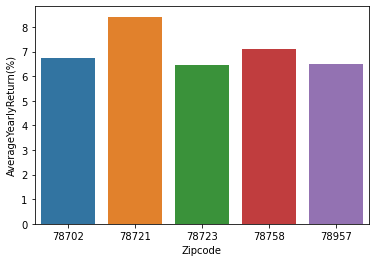

In [19]:
# Top 5 Zipcodes prior to modeling
ax = sns.barplot(x="Zipcode", y="AverageYearlyReturn(%)", data=austin_city_return[:5])

### 6.2 Modeling Iterations
Now we will use Grid Search ARIMA model to choose best parameters for each zip code. Let's start with one zip code to look the time series in detail.

#### Forecasting 78613 Zip Code: 

In [20]:
# Representative zipcode:
df_final[78613]

time
2009-01-01    205300.0
2009-02-01    205000.0
2009-03-01    204700.0
2009-04-01    204600.0
2009-05-01    204300.0
                ...   
2017-12-01    296200.0
2018-01-01    295900.0
2018-02-01    296400.0
2018-03-01    297500.0
2018-04-01    297300.0
Freq: MS, Name: 78613, Length: 112, dtype: float64

In [21]:
# Get the rolling mean and rolling standard deviation, using a 12-month window
roll_mean = df_final[78613].rolling(window=12, center=False).mean()
roll_std = df_final[78613].rolling(window=12, center=False).std()

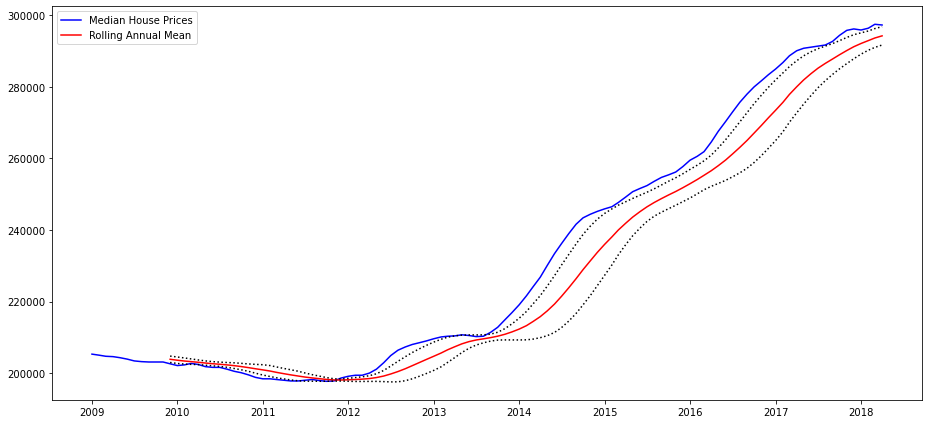

In [22]:
# Visualize the time series with rolling annual mean
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_final[78613], color='blue',
        label='Median House Prices')

ax.plot(roll_mean, color='red', label='Rolling Annual Mean')

ax.plot(roll_mean + roll_std, color='black', linestyle='dotted')
ax.plot(roll_mean - roll_std, color='black', linestyle='dotted')

ax.legend()
fig.tight_layout()

- Data is not stationary, it has upward trend.

In [23]:
# Stationarity test:
adfuller(df_final[78613])

(-0.23428318921425612,
 0.9343098582167807,
 7,
 104,
 {'1%': -3.4948504603223145,
  '5%': -2.889758398668639,
  '10%': -2.5818220155325444},
 1447.0150004986867)

p-value= 0.93, original data is not stationary.

In [24]:
# Take the log transform:
adfuller(np.log(df_final[78613]))

(-0.16997050832545965,
 0.9420076733077007,
 7,
 104,
 {'1%': -3.4948504603223145,
  '5%': -2.889758398668639,
  '10%': -2.5818220155325444},
 -979.8612379667757)

p-value= 0.94, log transformed data is not stationary.

In [25]:
# Take difference to make data stationary:
diff_df = df_final[78613].diff(periods=2).dropna()
adfuller(diff_df)

(-2.3227539918323172,
 0.16473433101872675,
 5,
 104,
 {'1%': -3.4948504603223145,
  '5%': -2.889758398668639,
  '10%': -2.5818220155325444},
 1423.2476463021642)

p-value= 0.16, taking 2 period difference of the data helped a little, but it still not stationary.

In [26]:
# Subtact rolling average:
df_minus_roll_mean = df_final[78613] - roll_mean
df_minus_roll_mean.dropna(inplace=True)
adfuller(df_minus_roll_mean)

(-1.7717411965046905,
 0.39457888198107743,
 7,
 93,
 {'1%': -3.502704609582561,
  '5%': -2.8931578098779522,
  '10%': -2.583636712914788},
 1277.2041126454785)

p-value= 0.39, data is not stationary.

In [27]:
# Calculate weighted rolling mean:
exp_roll_mean = df_final[78613].ewm(halflife=2).mean()
adfuller(df_final[78613] - exp_roll_mean)

(-2.287478096240888,
 0.1760383441230493,
 6,
 105,
 {'1%': -3.4942202045135513,
  '5%': -2.889485291005291,
  '10%': -2.5816762131519275},
 1378.9344430755878)

p-value= 0.17, data is not stationary.

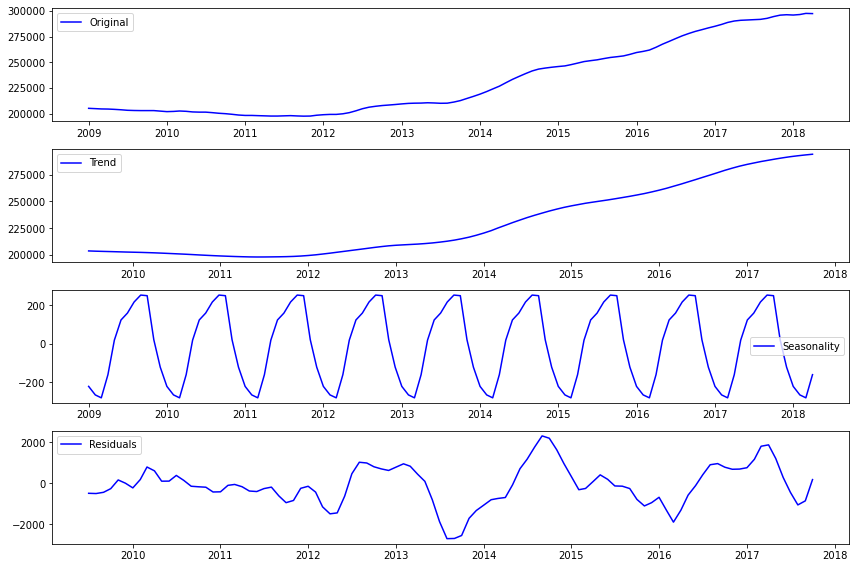

In [28]:
# Look into time series decomposition:
decomposition = seasonal_decompose(df_final[78613], model='additive')

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df_final[78613], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

- We have upward trend, and 12 month period seasonality in the time series.

##### Run Grid Search ARIMA model with Train-Test Split: 

In [29]:
# Train-test split
cutoff = '2016-04-01'

# Define train and test sets according to the cutoff defined above
train = df_final[78613][:cutoff]
test = df_final[78613][cutoff:]

In [30]:
# The code in this cell is written collaboratively with the other group working on this project.
# Define function for grid search ARIMA with hyperparameters:
def run_auto_arima(series):
    
    #(p, d, q) order will be chosen with the grid serch for each time series:
    gridsearch = pm.auto_arima(series,
                            start_p = 0,
                            max_p = 3,
                            d = 0, 
                            max_d = 3, 
                            start_q = 0,
                            max_q = 3,
                            seasonal=True,
                            m = 12,  # we have 12 month of seasonality
                            suppress_warnings=True, error_action='ignore')
    
    model = ARIMA(series, 
                  order = gridsearch.order, 
                  seasonal_order = gridsearch.seasonal_order,
                  enforce_stationarity=False)

    
    return model.fit()

# Define function for in-sample prediction and out-sample forecasting:
def run_arima_model(series, start, end):
    
    logged_series = np.log(series)
    
    model = run_auto_arima(logged_series)
    
    log_prediction = model.predict(start, end)  
    
    log_forecast = model.get_forecast(36)  # want to forecast 36 more months after the cutoff
    
    prediction = np.e ** log_prediction
    
    forecast = np.e** log_forecast.summary_frame()
    
    prediction_df = pd.DataFrame(prediction.values, prediction.index)
    
    return series, prediction_df, forecast

We have 112 months in our series for each zipcode.
We want to forecast 12 more months into the future.

In [31]:
# Run grid search ARIMA for zipcode 78613
original_series, prediction_series, forecast = run_arima_model(train, 0, 123)

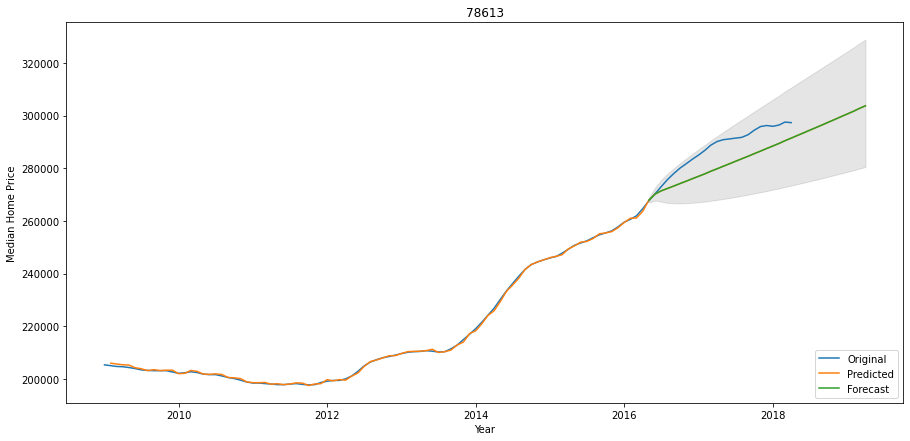

In [32]:
# Plot predictions, forecast and original data together:
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(df_final[78613])
plt.plot(prediction_series[1:])
plt.plot(forecast['mean'])
ax.fill_between(forecast.index, forecast['mean_ci_lower'], forecast['mean_ci_upper'], color='k', alpha=0.1);
plt.title('78613')
plt.legend(['Original','Predicted', 'Forecast'], loc='lower right')
plt.xlabel('Year')
plt.ylabel('Median Home Price')
plt.show()

In [33]:
# These metrics are used to evaluate model performance:
# Function is from Time Series review notebook
def report_metrics(y_true, y_pred):
    print("Explained Variance:\n\t", metrics.explained_variance_score(y_true, y_pred))
    print("MAE:\n\t", metrics.mean_absolute_error(y_true, y_pred))
    print("RMSE:\n\t", metrics.mean_squared_error(y_true, y_pred, squared=False))
    print("r^2:\n\t", metrics.r2_score(y_true, y_pred))
    
report_metrics(df_final[78613][1:], prediction_series[1:-12])

Explained Variance:
	 0.9915310447429279
MAE:
	 1748.9412593968468
RMSE:
	 3512.8853803611537
r^2:
	 0.9897036650385482


- We got 99% explained variance with grid search ARIMA model for 78613 zip code.

#### Forecasting All Zip Codes in Austin Metro Area:

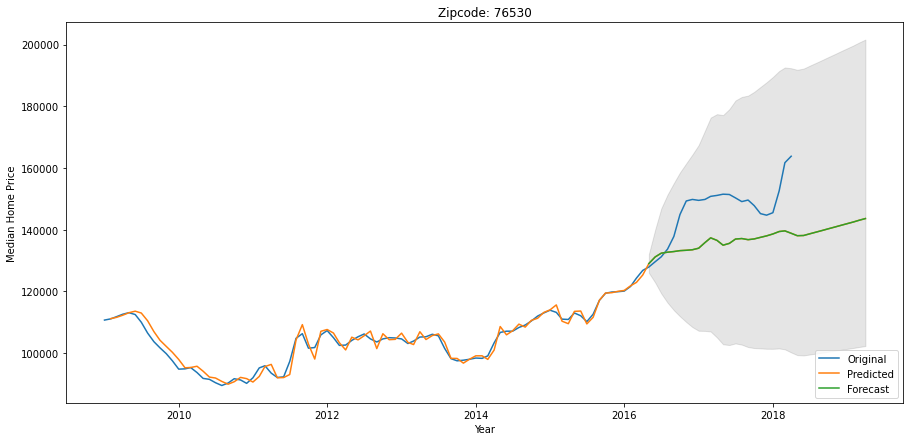

Zipcode: 76530
Explained Variance:
	 0.909162232267951
MAE:
	 3411.553100077576
RMSE:
	 6221.262686536085
r^2:
	 0.8969909207397229
Expected ROI for 76530: -0.12331751443695588


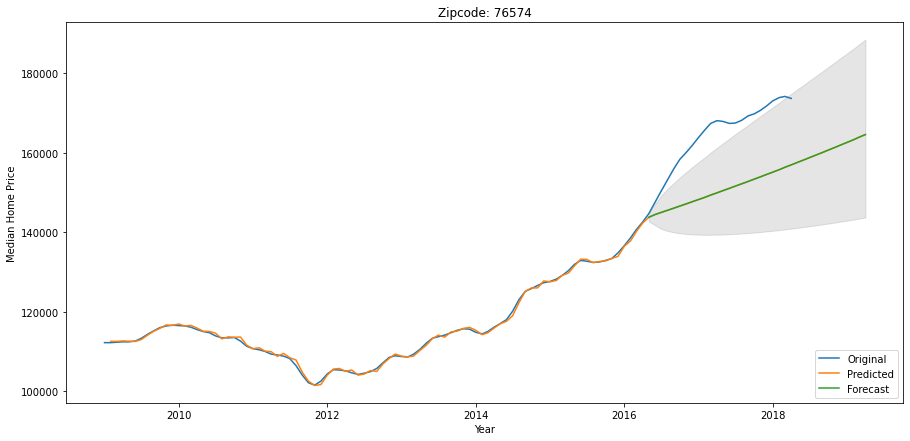

Zipcode: 76574
Explained Variance:
	 0.9194801886838533
MAE:
	 3313.1914494373527
RMSE:
	 6949.998745633775
r^2:
	 0.9003933957956365
Expected ROI for 76574: -0.05242421350735626


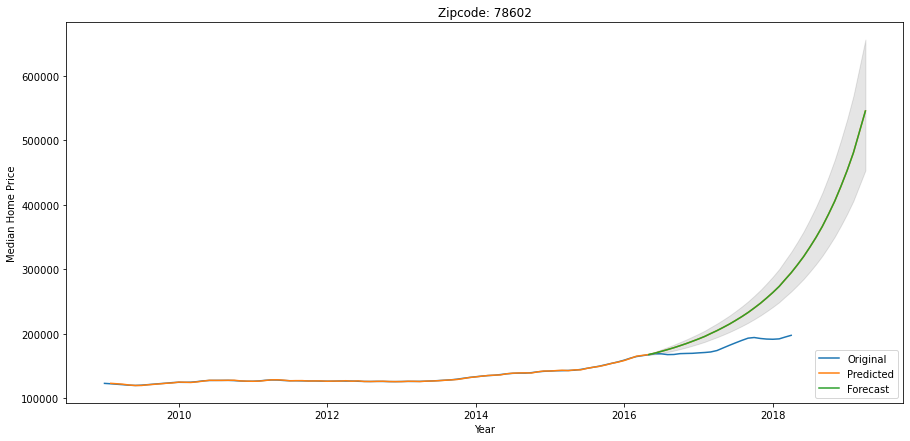

Zipcode: 78602
Explained Variance:
	 0.25091503949421345
MAE:
	 7913.630511907523
RMSE:
	 20863.738846007745
r^2:
	 0.13207226802203942
Expected ROI for 78602: 1.7610121773445064


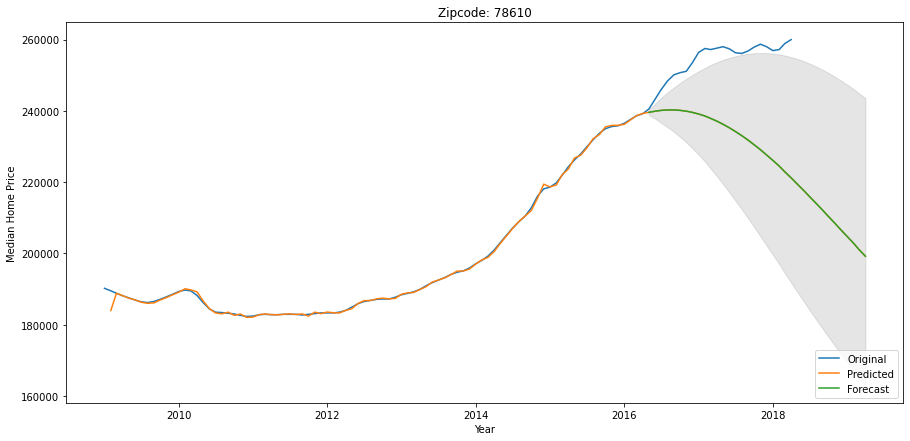

Zipcode: 78610
Explained Variance:
	 0.8878648178483416
MAE:
	 4556.313433418147
RMSE:
	 10448.851322822142
r^2:
	 0.8638258996902213
Expected ROI for 78610: -0.23381734275095437


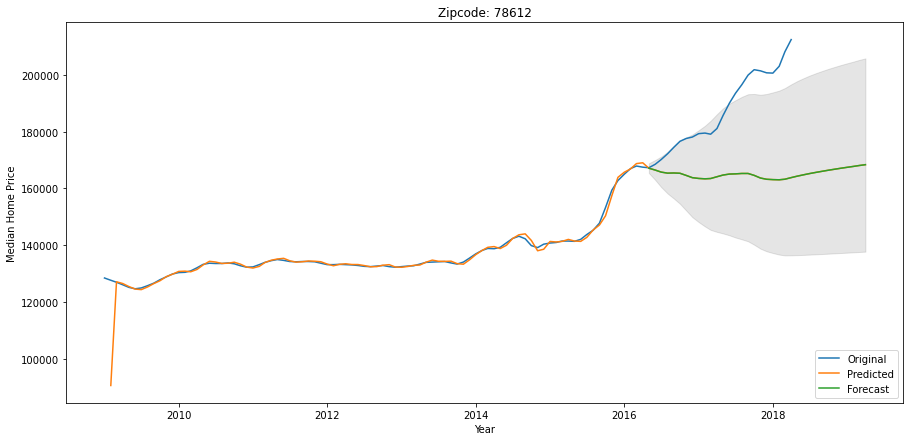

Zipcode: 78612
Explained Variance:
	 0.738420557541072
MAE:
	 5639.812749171654
RMSE:
	 12986.662391587002
r^2:
	 0.6872049247669385
Expected ROI for 78612: -0.2072676327472513


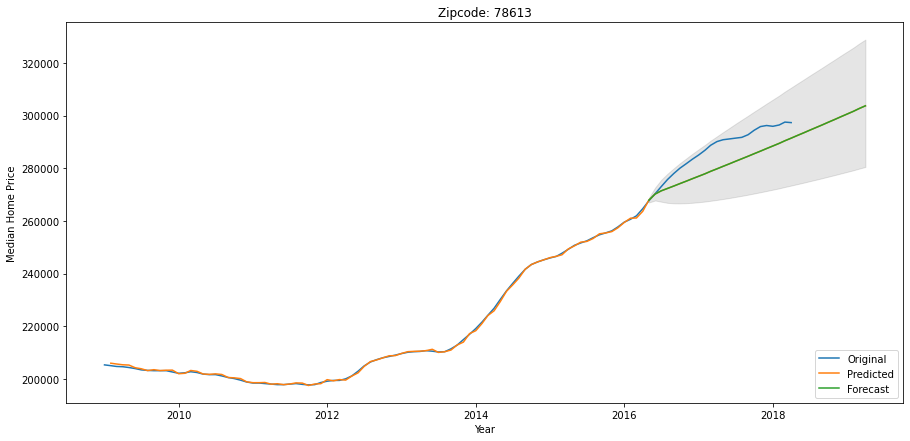

Zipcode: 78613
Explained Variance:
	 0.9915310447429279
MAE:
	 1748.9412593968468
RMSE:
	 3512.8853803611537
r^2:
	 0.9897036650385482
Expected ROI for 78613: 0.021468135409514776


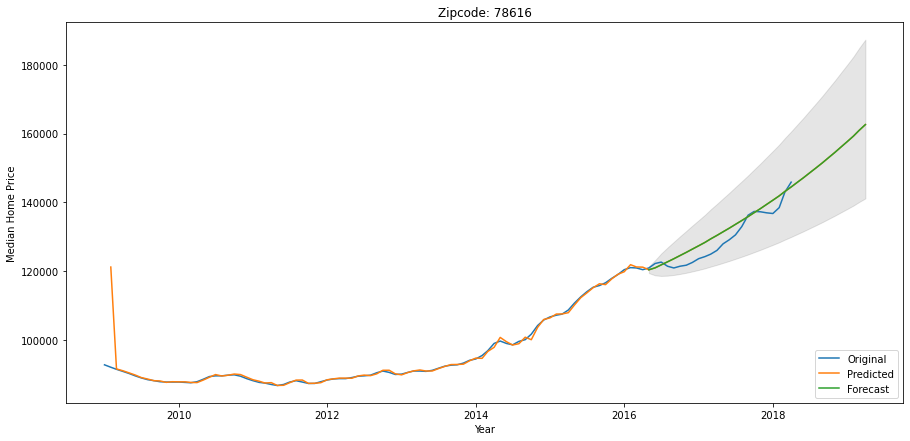

Zipcode: 78616
Explained Variance:
	 0.968871596928736
MAE:
	 1013.1911155925073
RMSE:
	 3074.726863517169
r^2:
	 0.9670962247508188
Expected ROI for 78616: 0.114463980762676


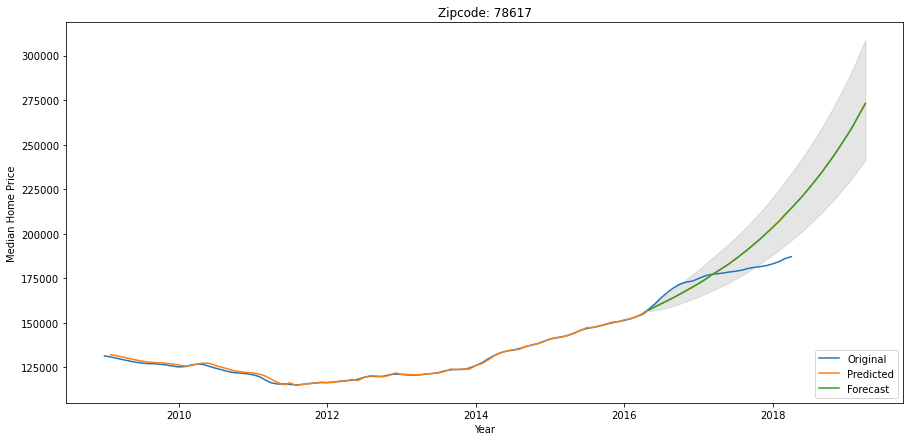

Zipcode: 78617
Explained Variance:
	 0.9407262043096282
MAE:
	 2325.939063226719
RMSE:
	 5614.294119261259
r^2:
	 0.9358610169882389
Expected ROI for 78617: 0.45951744087770247


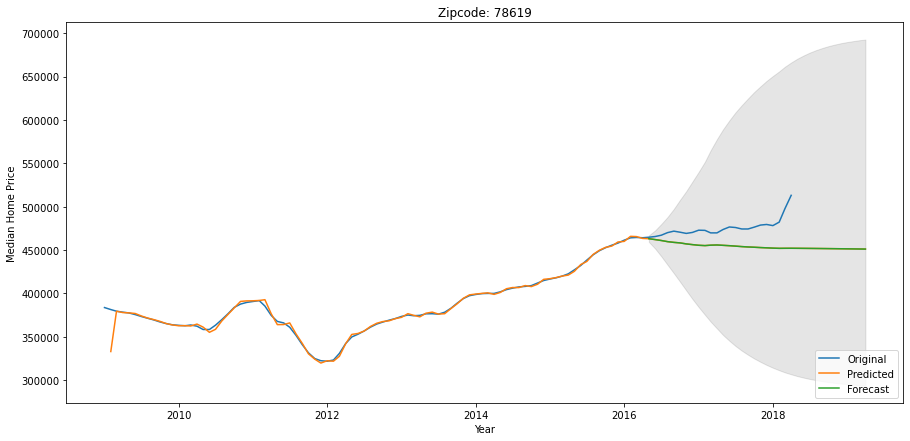

Zipcode: 78619
Explained Variance:
	 0.947697354049903
MAE:
	 5671.46894054999
RMSE:
	 11947.656497110242
r^2:
	 0.9383507828120701
Expected ROI for 78619: -0.12079203348425042


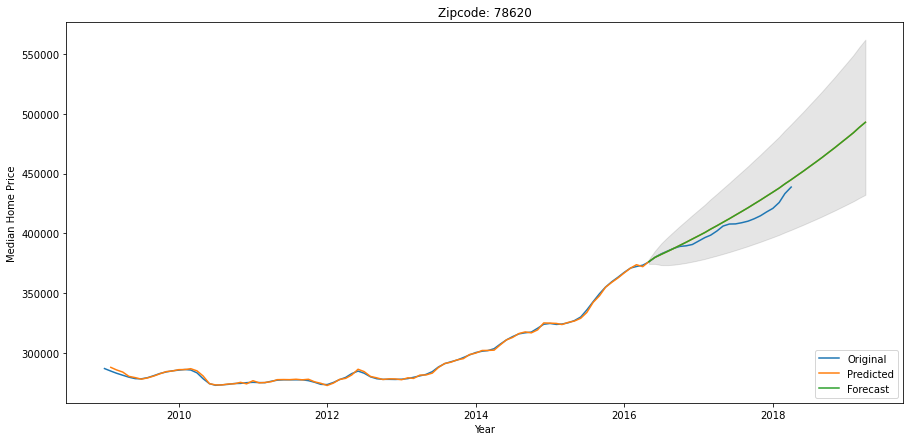

Zipcode: 78620
Explained Variance:
	 0.9957180766469141
MAE:
	 1826.4580001981572
RMSE:
	 3580.8105124615745
r^2:
	 0.9950107303411814
Expected ROI for 78620: 0.12344628479153447


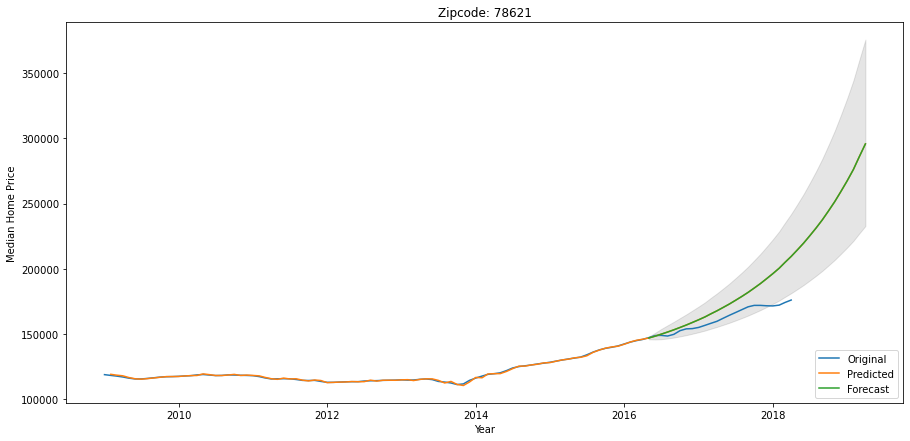

Zipcode: 78621
Explained Variance:
	 0.8892992738933012
MAE:
	 2601.520315548588
RMSE:
	 6769.234954549085
r^2:
	 0.8740482083433552
Expected ROI for 78621: 0.6801848853802512


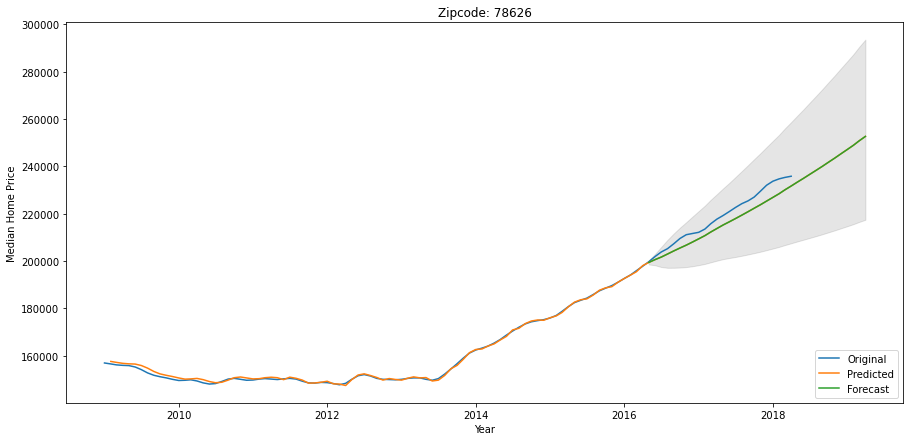

Zipcode: 78626
Explained Variance:
	 0.9949889421653906
MAE:
	 1250.474702486909
RMSE:
	 2081.2778799402745
r^2:
	 0.9944182342202443
Expected ROI for 78626: 0.07135729749211887


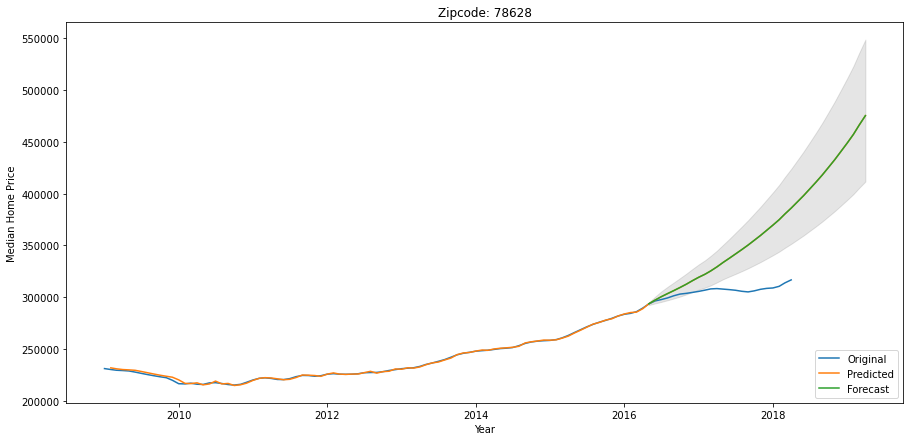

Zipcode: 78628
Explained Variance:
	 0.7661811192456791
MAE:
	 6797.868403707234
RMSE:
	 17299.447990378667
r^2:
	 0.7277827909108991
Expected ROI for 78628: 0.5003809292391316


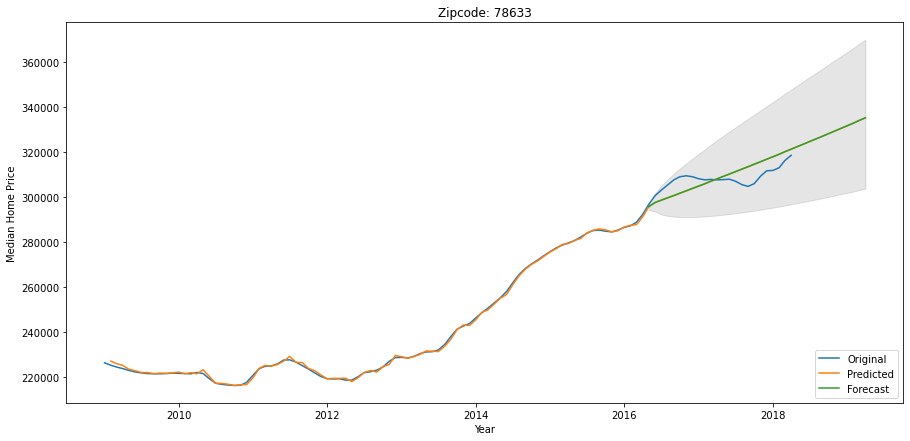

Zipcode: 78633
Explained Variance:
	 0.995183446371585
MAE:
	 1390.206309194526
RMSE:
	 2467.597406208425
r^2:
	 0.9951594065888638
Expected ROI for 78633: 0.05230598327278752


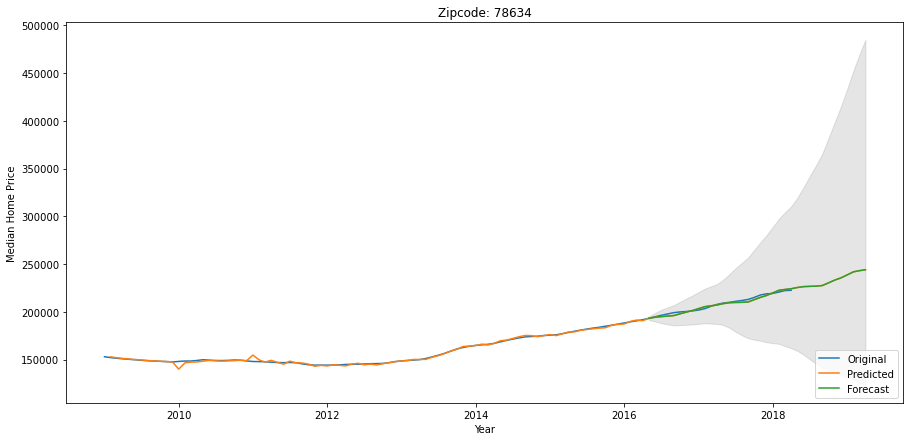

Zipcode: 78634
Explained Variance:
	 0.9966736969174443
MAE:
	 909.8635418934662
RMSE:
	 1431.3741584547913
r^2:
	 0.996606747605572
Expected ROI for 78634: 0.0968215173439336


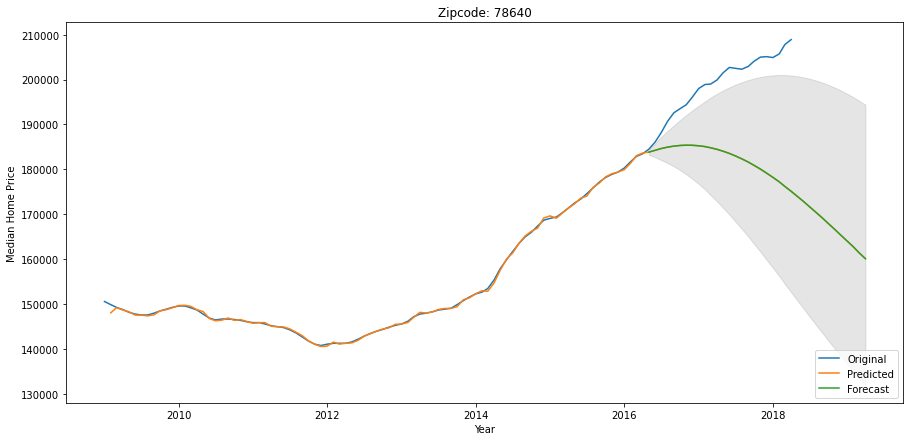

Zipcode: 78640
Explained Variance:
	 0.8649534440877593
MAE:
	 3725.229746758059
RMSE:
	 8781.357277693578
r^2:
	 0.8378031218207447
Expected ROI for 78640: -0.2334463103210264


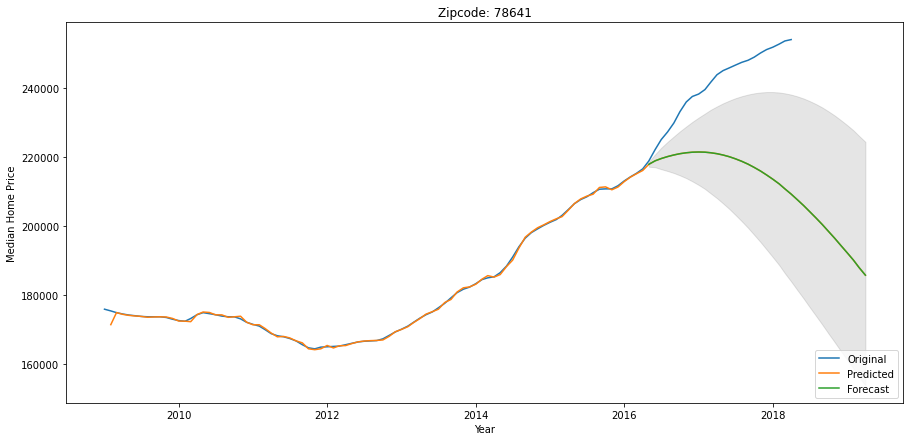

Zipcode: 78641
Explained Variance:
	 0.849460503780418
MAE:
	 5195.191542994575
RMSE:
	 12227.607753190838
r^2:
	 0.8188118397228499
Expected ROI for 78641: -0.2689150204337294


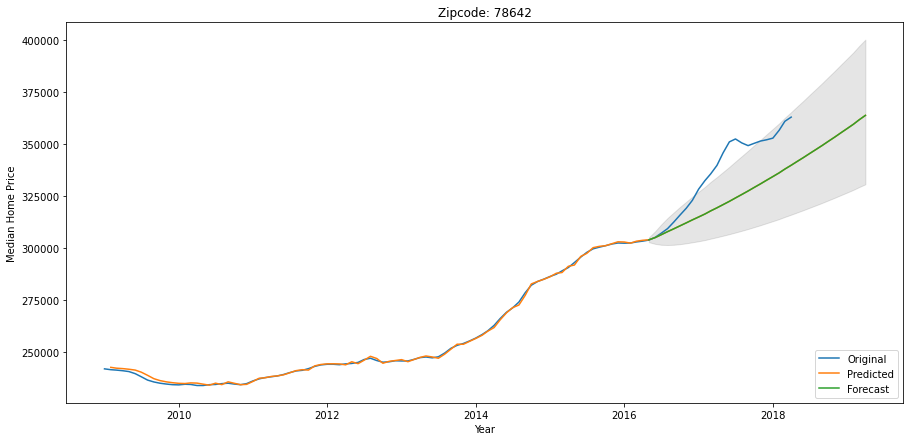

Zipcode: 78642
Explained Variance:
	 0.9621235800590056
MAE:
	 3761.701732698908
RMSE:
	 8380.809531990219
r^2:
	 0.9558252357276095
Expected ROI for 78642: 0.00228252043211986


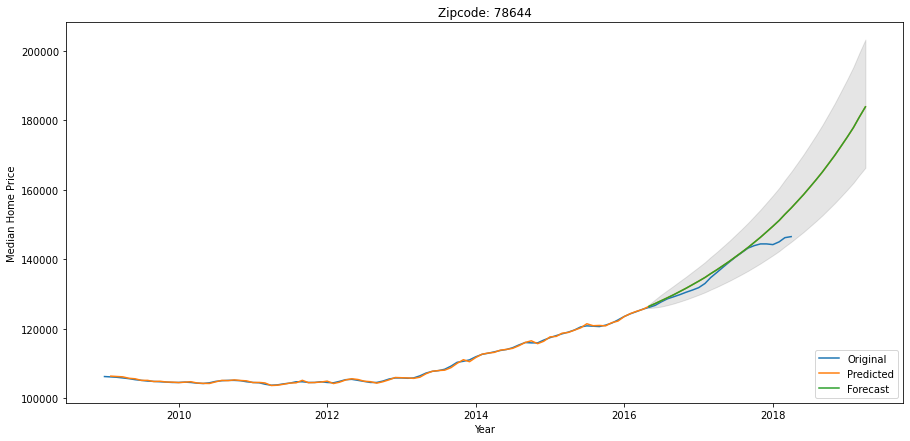

Zipcode: 78644
Explained Variance:
	 0.9896140865752799
MAE:
	 539.3145915474637
RMSE:
	 1387.1319092340605
r^2:
	 0.9886267221362792
Expected ROI for 78644: 0.25509184324344497


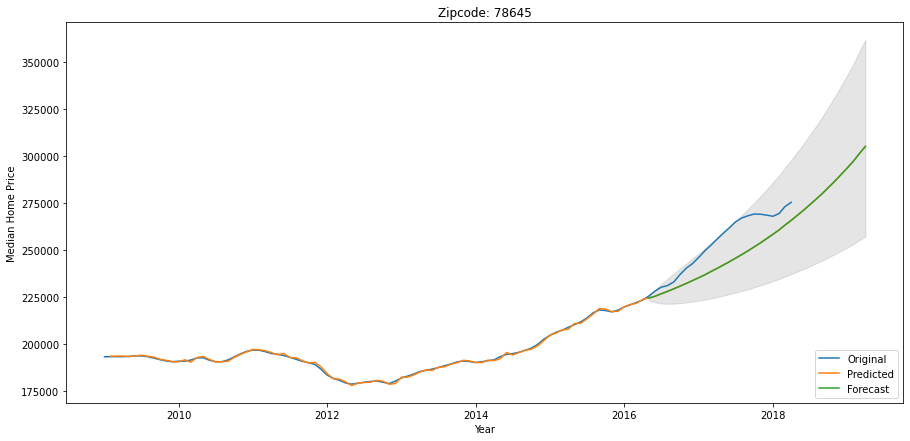

Zipcode: 78645
Explained Variance:
	 0.9624437179311781
MAE:
	 2738.5875326043815
RMSE:
	 5796.855643922227
r^2:
	 0.9547668530171186
Expected ROI for 78645: 0.10800699601010164


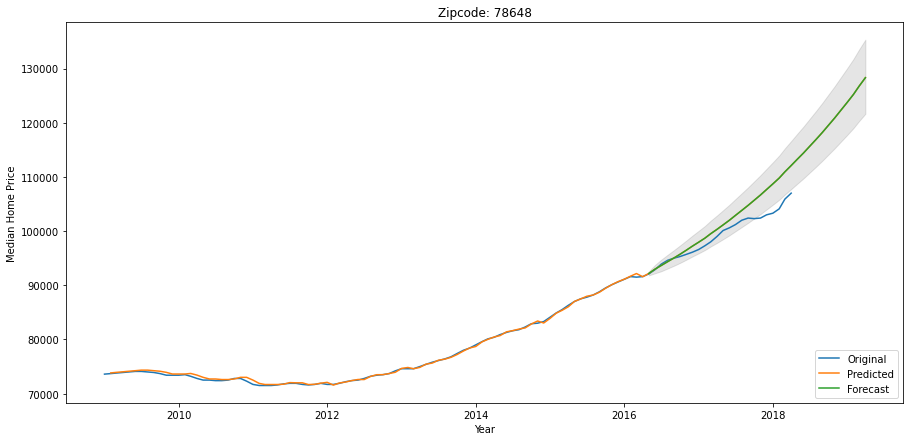

Zipcode: 78648
Explained Variance:
	 0.9871729283437176
MAE:
	 589.0330372111006
RMSE:
	 1322.0060124071133
r^2:
	 0.9848640656001144
Expected ROI for 78648: 0.19918709184747177


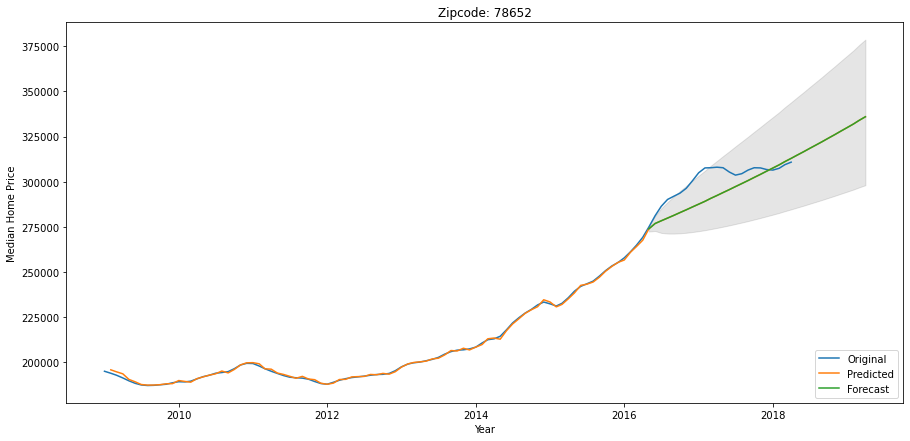

Zipcode: 78652
Explained Variance:
	 0.9897942347914457
MAE:
	 2197.985052169413
RMSE:
	 4687.861733602619
r^2:
	 0.9884039022375228
Expected ROI for 78652: 0.08101863898890048


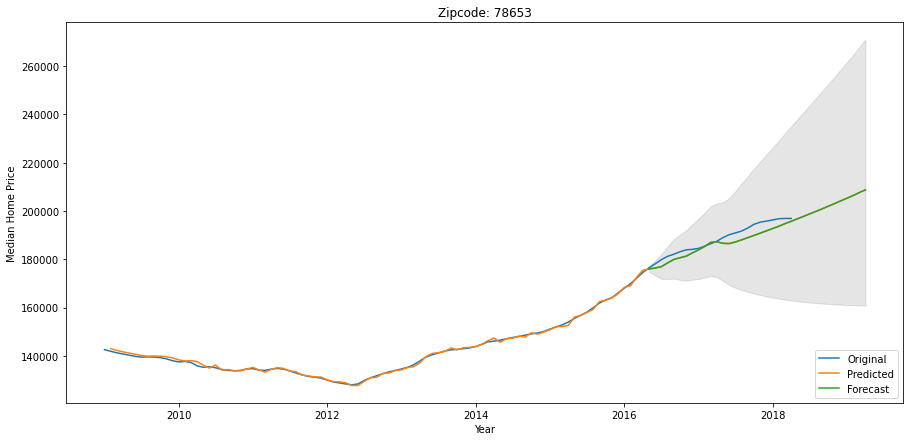

Zipcode: 78653
Explained Variance:
	 0.9961392029507878
MAE:
	 894.0937653318456
RMSE:
	 1404.8070118178248
r^2:
	 0.9957739549410888
Expected ROI for 78653: 0.060136232495097086


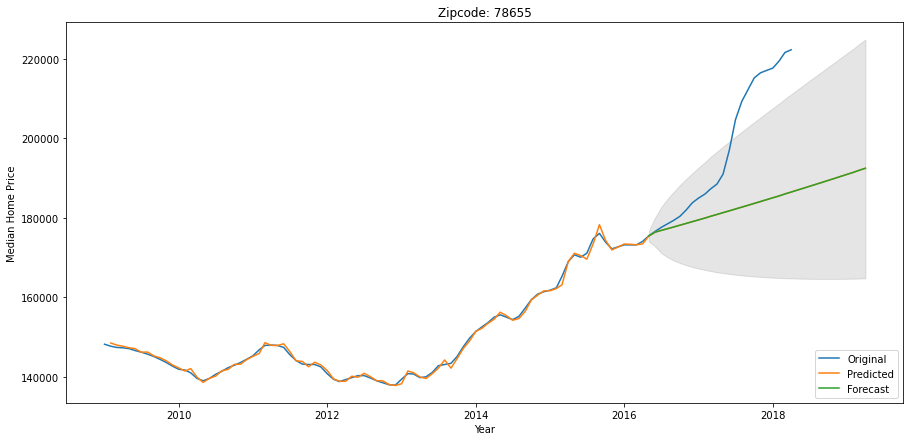

Zipcode: 78655
Explained Variance:
	 0.8452840691965622
MAE:
	 3766.433791273332
RMSE:
	 9730.95536607875
r^2:
	 0.8238773745635375
Expected ROI for 78655: -0.13413539202957128


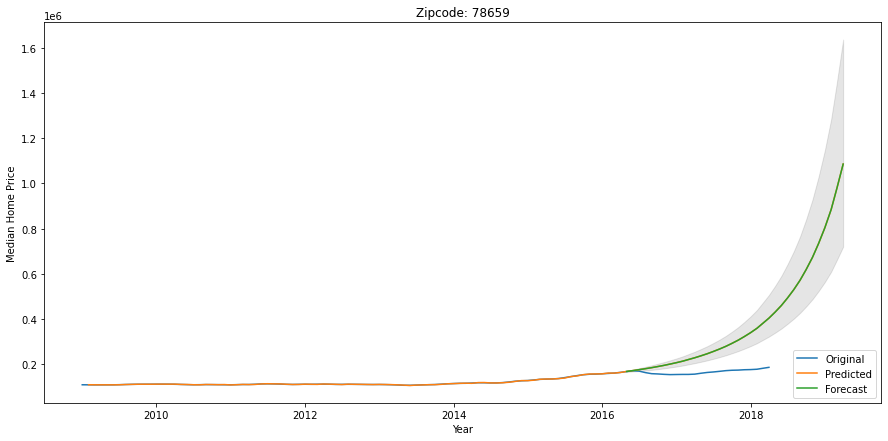

Zipcode: 78659
Explained Variance:
	 -2.5084125637767416
MAE:
	 18704.138655730698
RMSE:
	 48768.01070483351
r^2:
	 -3.087515240190819
Expected ROI for 78659: 4.848024792600987


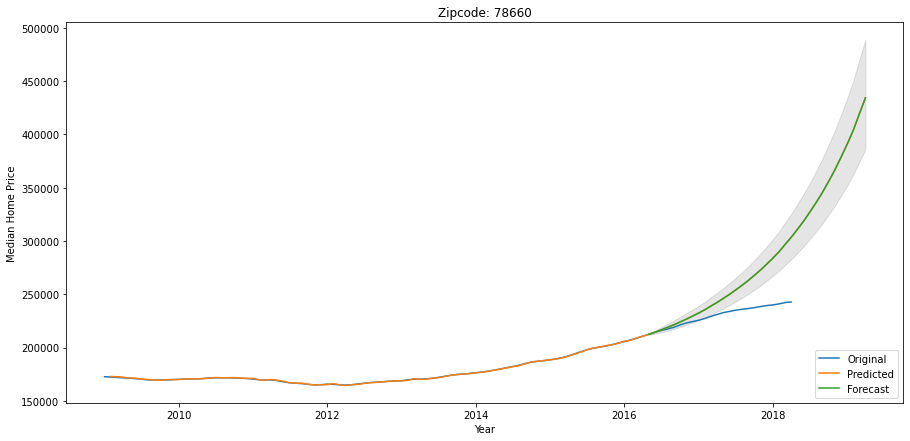

Zipcode: 78660
Explained Variance:
	 0.7793406678968033
MAE:
	 4301.067472652781
RMSE:
	 12348.473122898462
r^2:
	 0.7511785672839237
Expected ROI for 78660: 0.7889733894423996


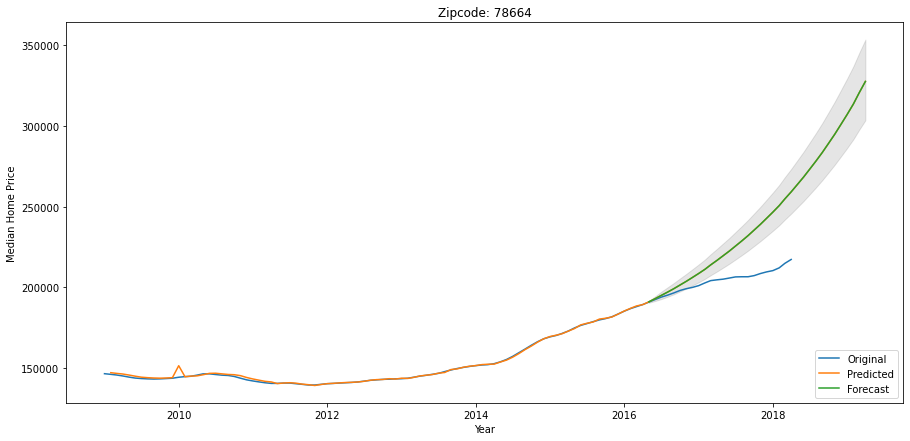

Zipcode: 78664
Explained Variance:
	 0.8573243383420315
MAE:
	 3996.66808829704
RMSE:
	 10167.42486770552
r^2:
	 0.833117549088542
Expected ROI for 78664: 0.5070448038087514


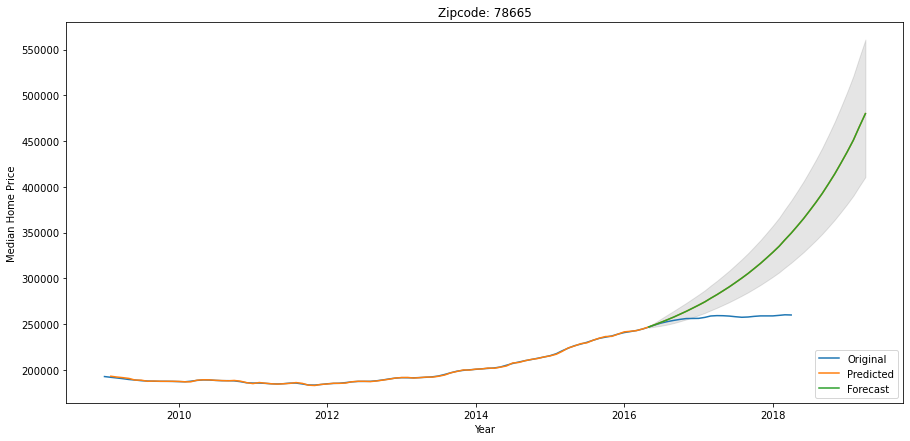

Zipcode: 78665
Explained Variance:
	 0.5677902794655894
MAE:
	 7290.189799434086
RMSE:
	 19951.1664964364
r^2:
	 0.5056605350016594
Expected ROI for 78665: 0.8467681349509207


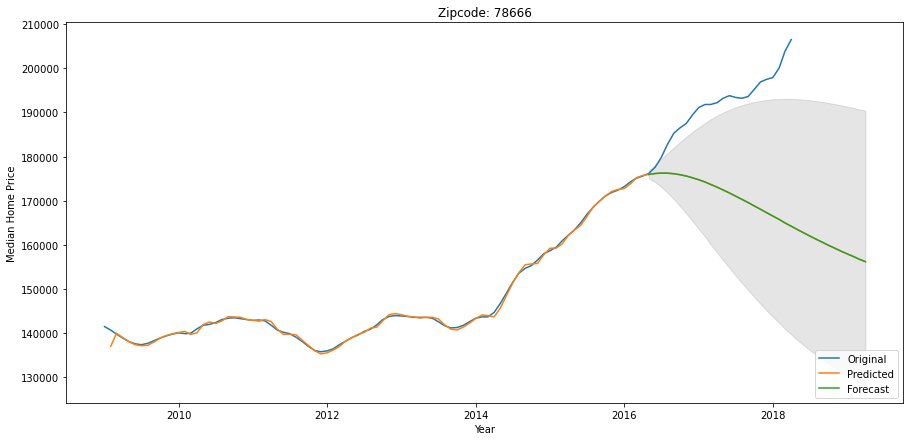

Zipcode: 78666
Explained Variance:
	 0.7927427532688085
MAE:
	 4528.79572123829
RMSE:
	 10525.341969919456
r^2:
	 0.750549051460698
Expected ROI for 78666: -0.2435426306707413


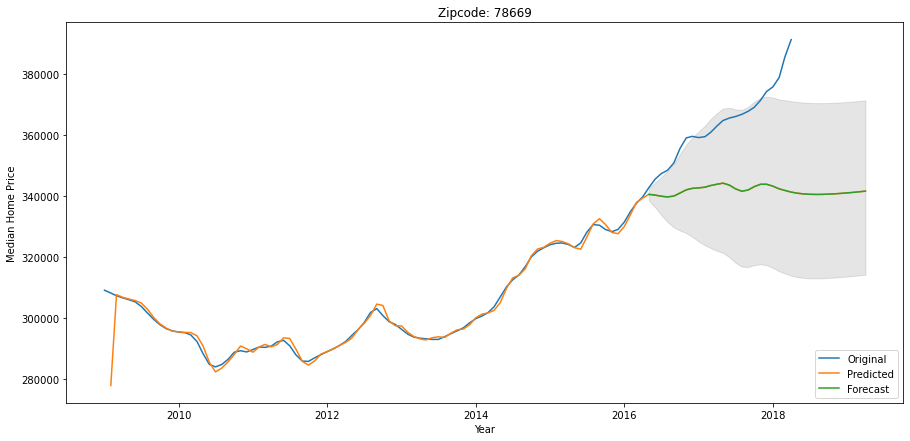

Zipcode: 78669
Explained Variance:
	 0.8627731370212457
MAE:
	 5494.919114072429
RMSE:
	 11700.696855104774
r^2:
	 0.8347280949557006
Expected ROI for 78669: -0.12687641724845966


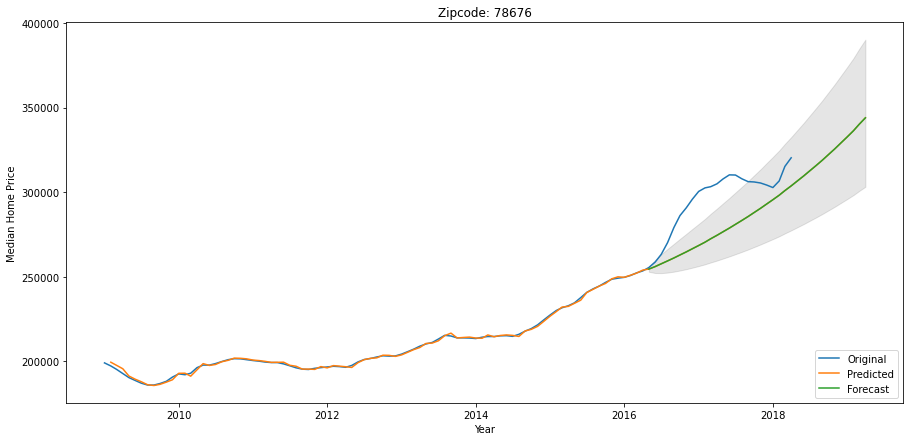

Zipcode: 78676
Explained Variance:
	 0.9451414823205969
MAE:
	 4687.542719926333
RMSE:
	 10255.98128871519
r^2:
	 0.9341079312755652
Expected ROI for 78676: 0.07380539270335626


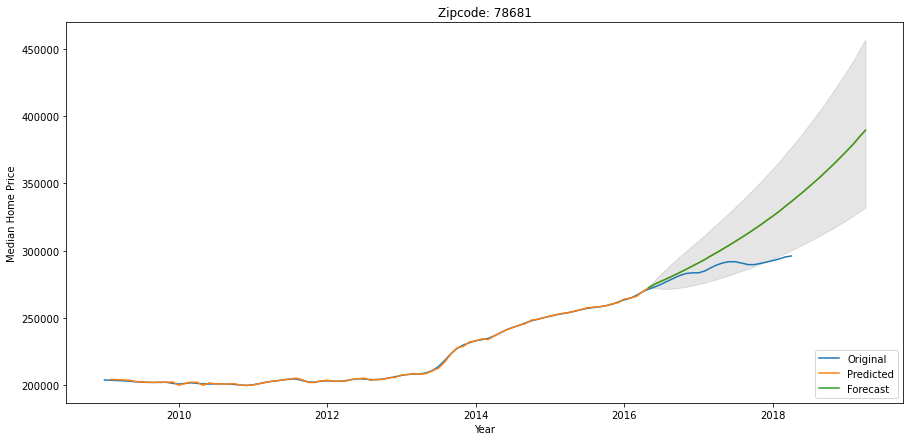

Zipcode: 78681
Explained Variance:
	 0.935291467752444
MAE:
	 3562.5991249541744
RMSE:
	 9297.62028298672
r^2:
	 0.9258047391452862
Expected ROI for 78681: 0.31554251338760475


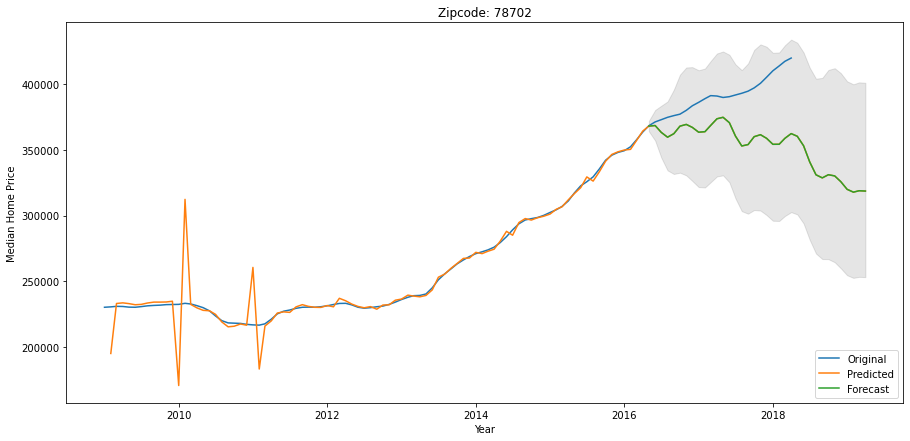

Zipcode: 78702
Explained Variance:
	 0.9240704906794809
MAE:
	 9265.172971903736
RMSE:
	 19183.967188613646
r^2:
	 0.9159218316280229
Expected ROI for 78702: -0.24106795581144855


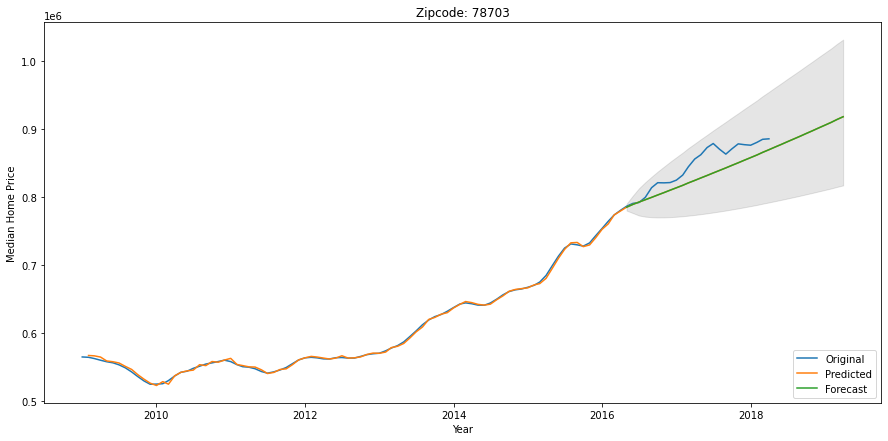

Zipcode: 78703
Explained Variance:
	 0.993163273300808
MAE:
	 5446.243814208315
RMSE:
	 10586.542309435023
r^2:
	 0.9919374339996623
Expected ROI for 78703: 0.0366785163025791


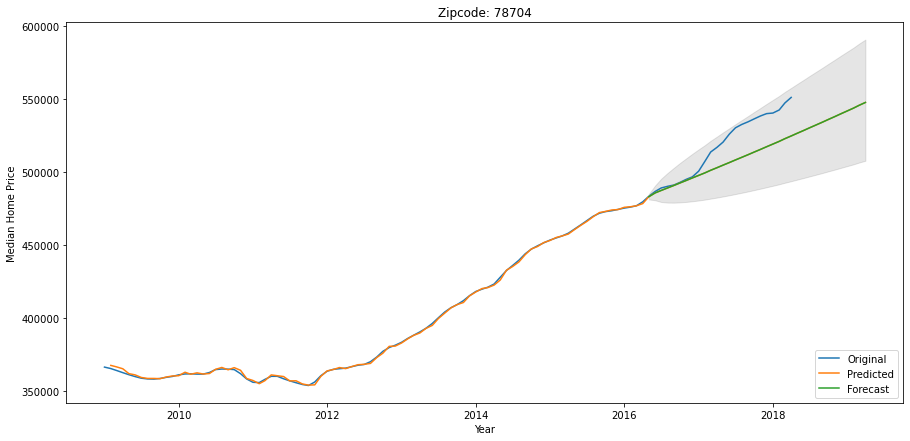

Zipcode: 78704
Explained Variance:
	 0.9873744274194257
MAE:
	 3272.0408206971406
RMSE:
	 7585.304346772037
r^2:
	 0.9854849909054267
Expected ROI for 78704: -0.006253589021539982


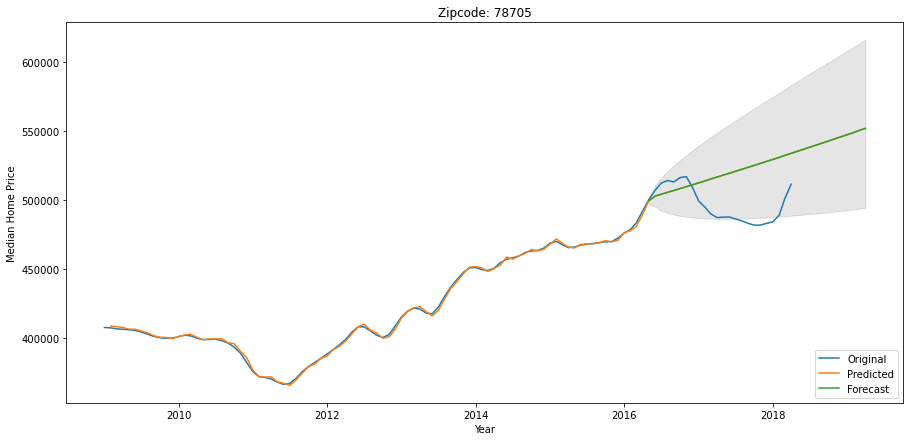

Zipcode: 78705
Explained Variance:
	 0.9179854727842124
MAE:
	 5963.310728930683
RMSE:
	 13360.288978914481
r^2:
	 0.9076232648642198
Expected ROI for 78705: 0.07908182357200937


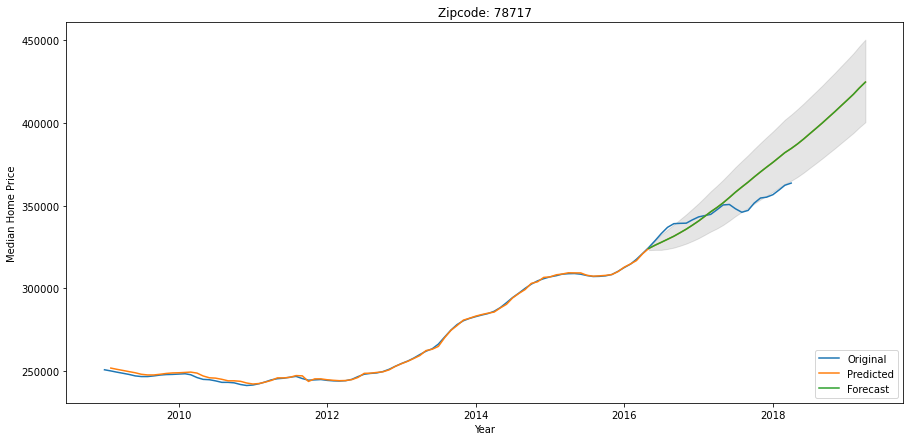

Zipcode: 78717
Explained Variance:
	 0.9829971117594172
MAE:
	 2476.7683077050033
RMSE:
	 5481.871192532037
r^2:
	 0.9814618804701707
Expected ROI for 78717: 0.16774437296582778


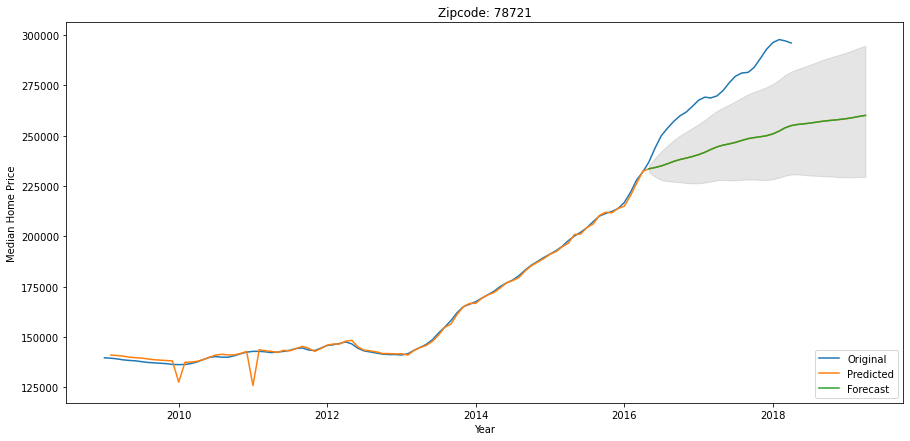

Zipcode: 78721
Explained Variance:
	 0.9395400568743469
MAE:
	 6983.417860086503
RMSE:
	 14420.029116540352
r^2:
	 0.9252696264701068
Expected ROI for 78721: -0.12147395409644633


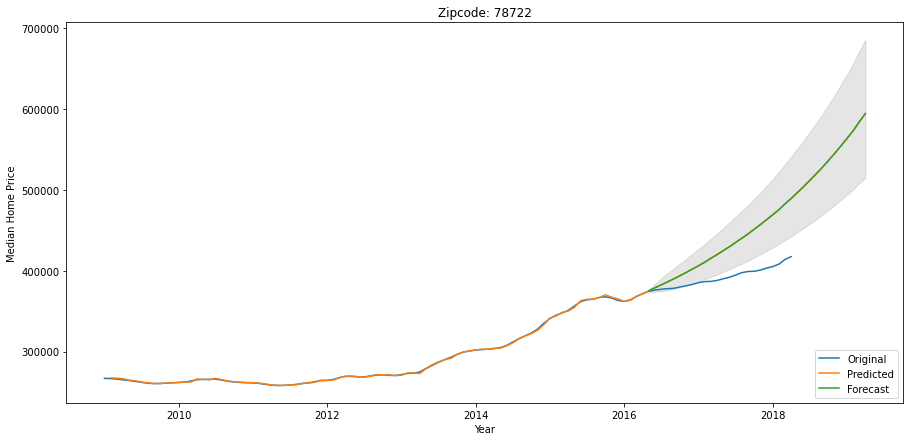

Zipcode: 78722
Explained Variance:
	 0.8917276696635009
MAE:
	 7905.939276788284
RMSE:
	 19050.596964620807
r^2:
	 0.8720269519326687
Expected ROI for 78722: 0.42442802805313923


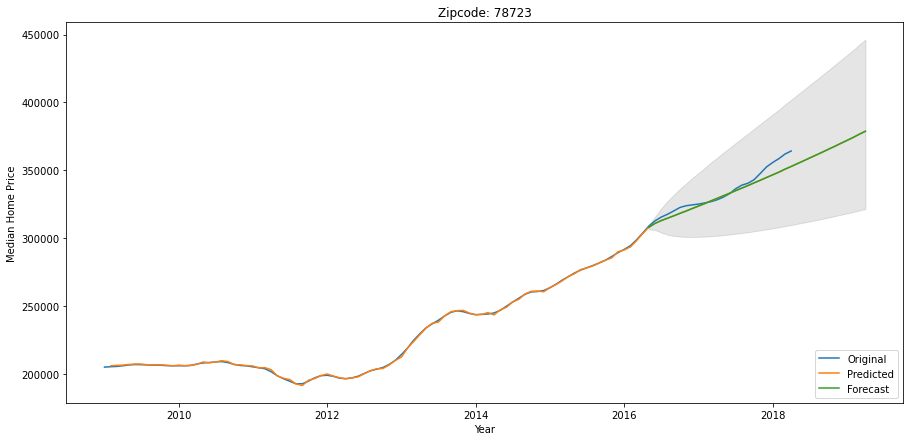

Zipcode: 78723
Explained Variance:
	 0.9980552177147862
MAE:
	 1164.5462971745949
RMSE:
	 2416.064766938784
r^2:
	 0.9978517632126699
Expected ROI for 78723: 0.03991543789837774


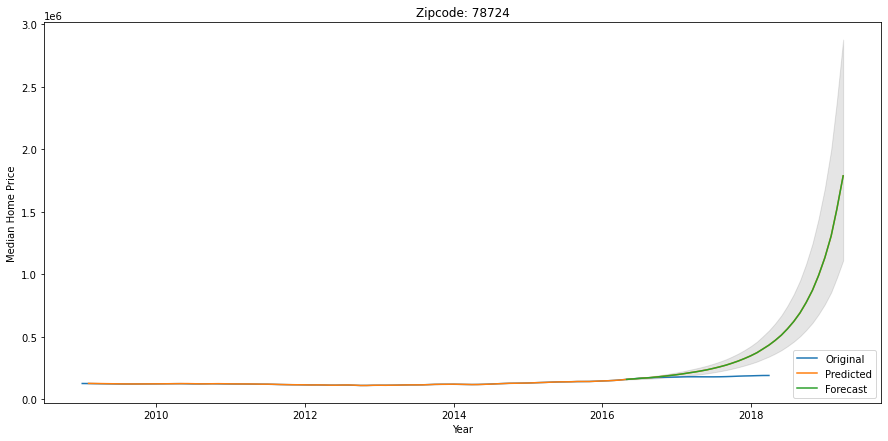

Zipcode: 78724
Explained Variance:
	 -2.159787679055567
MAE:
	 15243.861643620656
RMSE:
	 46178.81827266607
r^2:
	 -2.5332842690088215
Expected ROI for 78724: 8.444425209349571


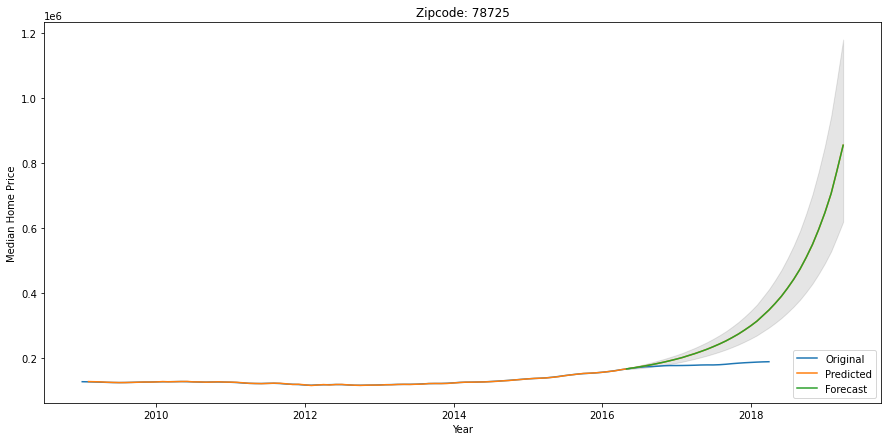

Zipcode: 78725
Explained Variance:
	 -0.7233216586706552
MAE:
	 11474.572856782466
RMSE:
	 32660.275248299942
r^2:
	 -0.9550343435415405
Expected ROI for 78725: 3.5397185650104057


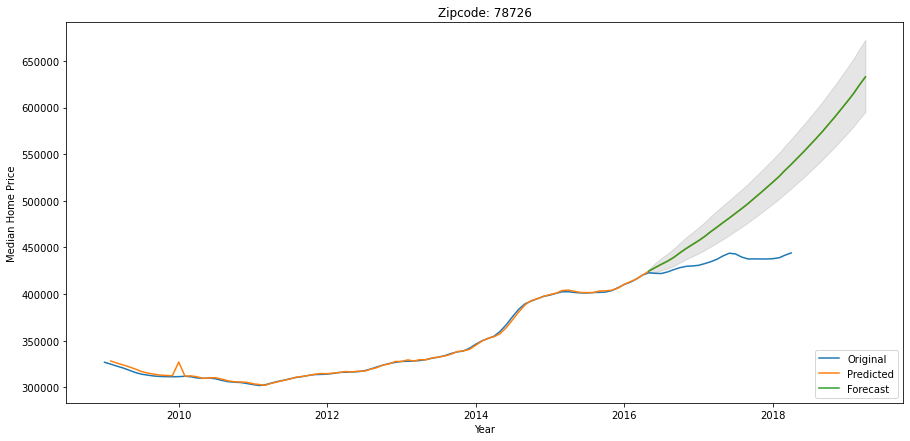

Zipcode: 78726
Explained Variance:
	 0.8157898959078725
MAE:
	 10042.047218466341
RMSE:
	 23889.503636903162
r^2:
	 0.7799307464805483
Expected ROI for 78726: 0.42507755958626453


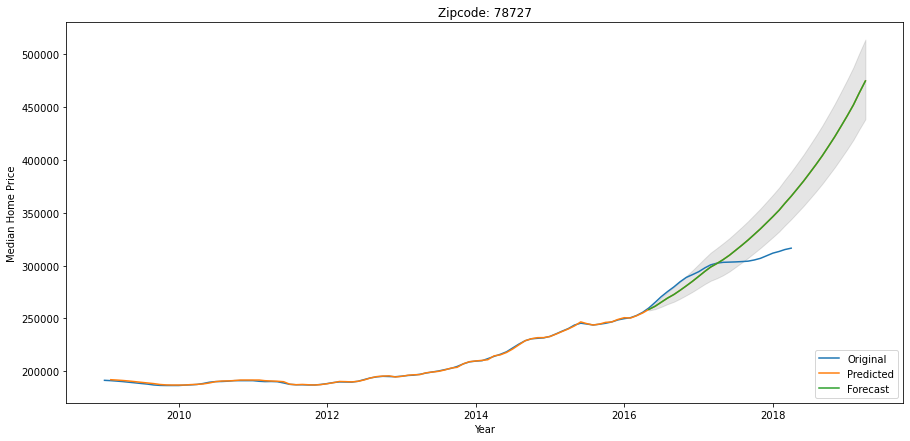

Zipcode: 78727
Explained Variance:
	 0.9507984618809786
MAE:
	 3604.9130902820784
RMSE:
	 9754.006023374743
r^2:
	 0.9476469047701033
Expected ROI for 78727: 0.5001219572026157


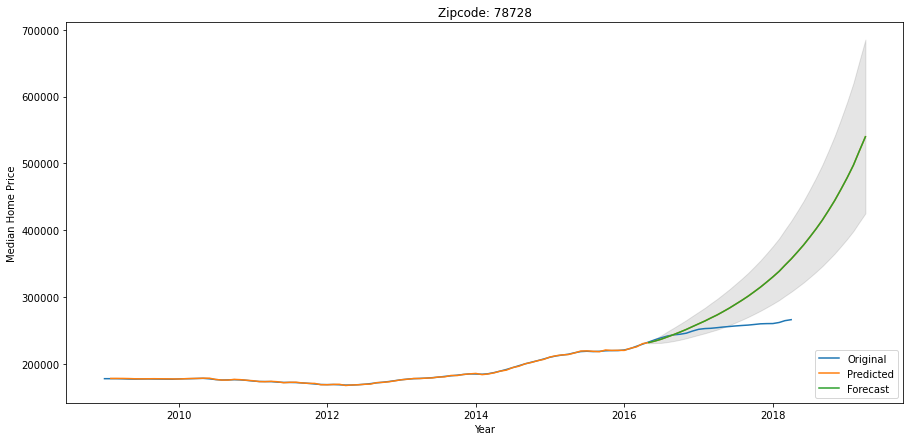

Zipcode: 78728
Explained Variance:
	 0.669425230040902
MAE:
	 6819.216460215423
RMSE:
	 19347.81819139854
r^2:
	 0.6276888780731358
Expected ROI for 78728: 1.0258704296078618


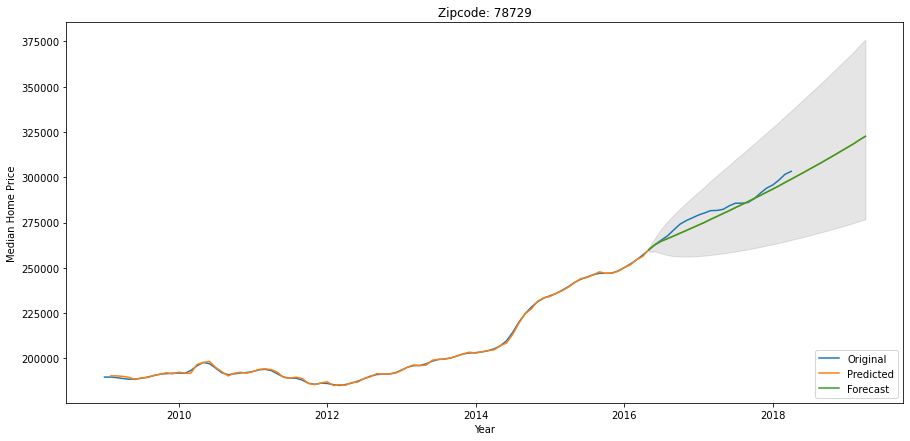

Zipcode: 78729
Explained Variance:
	 0.998333027384821
MAE:
	 910.6269467212587
RMSE:
	 1629.2222157907752
r^2:
	 0.9981077318962052
Expected ROI for 78729: 0.06374046882785143


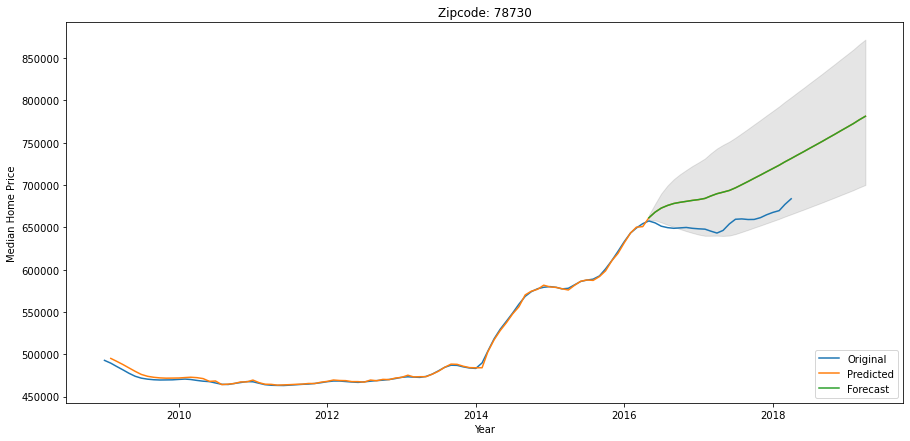

Zipcode: 78730
Explained Variance:
	 0.9572567163968072
MAE:
	 9303.464732106726
RMSE:
	 18607.249216172993
r^2:
	 0.9452712860605071
Expected ROI for 78730: 0.14265994419923309


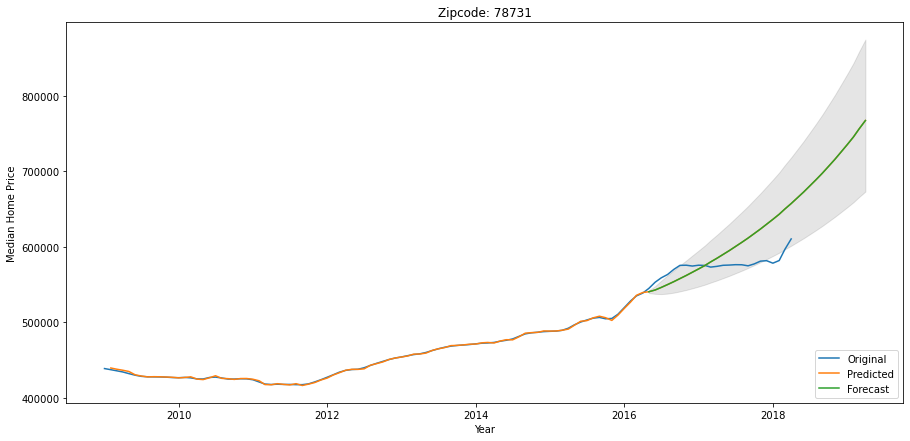

Zipcode: 78731
Explained Variance:
	 0.9414479211355682
MAE:
	 5877.190049596787
RMSE:
	 14342.879765809948
r^2:
	 0.9375260096574872
Expected ROI for 78731: 0.25674333383598275


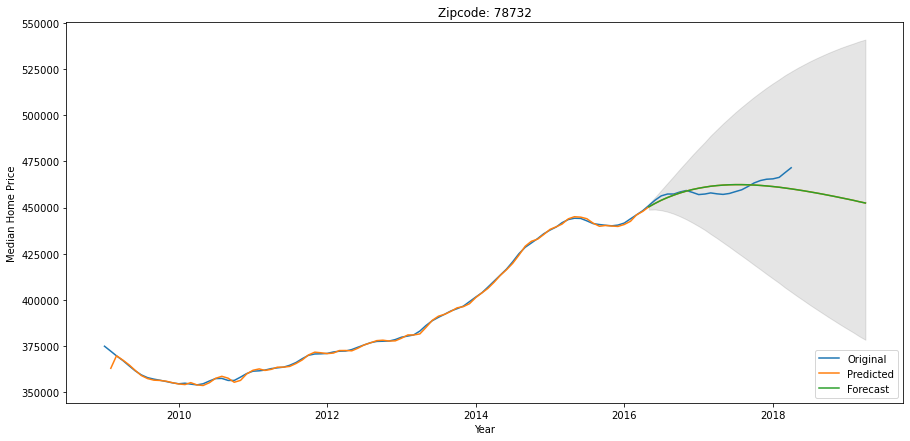

Zipcode: 78732
Explained Variance:
	 0.9971371937891069
MAE:
	 1187.2910448299533
RMSE:
	 2185.035813232703
r^2:
	 0.9970929490165237
Expected ROI for 78732: -0.0404432694547025


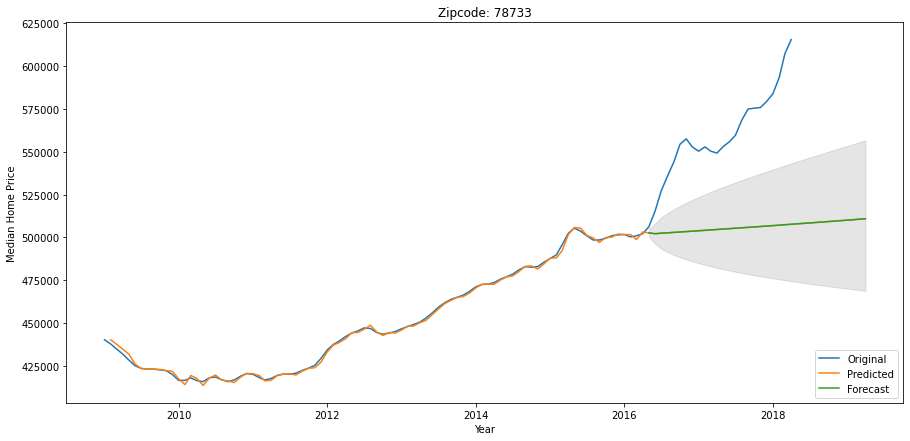

Zipcode: 78733
Explained Variance:
	 0.7769815393122069
MAE:
	 12648.330175801319
RMSE:
	 27977.022458165447
r^2:
	 0.7261231073297836
Expected ROI for 78733: -0.17008206007825155


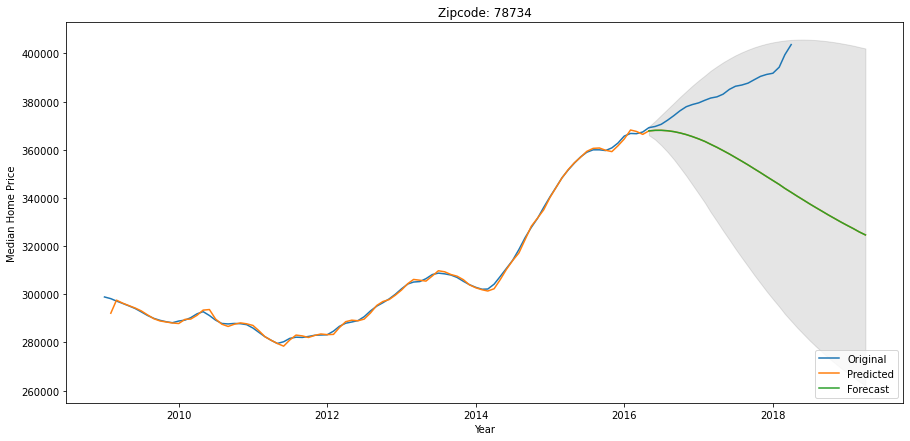

Zipcode: 78734
Explained Variance:
	 0.8906591554995621
MAE:
	 5887.299732933471
RMSE:
	 14121.930075629953
r^2:
	 0.8711943056087557
Expected ROI for 78734: -0.19578975953044336


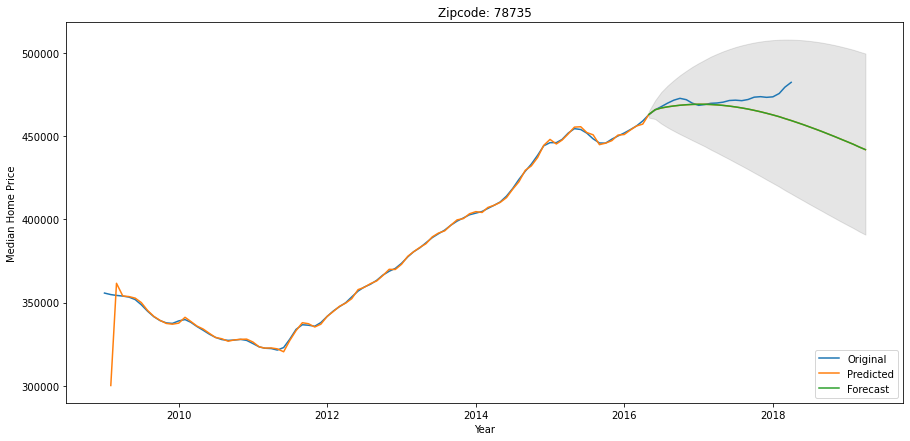

Zipcode: 78735
Explained Variance:
	 0.9872936649250735
MAE:
	 2208.1804326892725
RMSE:
	 6470.477295248765
r^2:
	 0.9865092354166275
Expected ROI for 78735: -0.08374722525864355


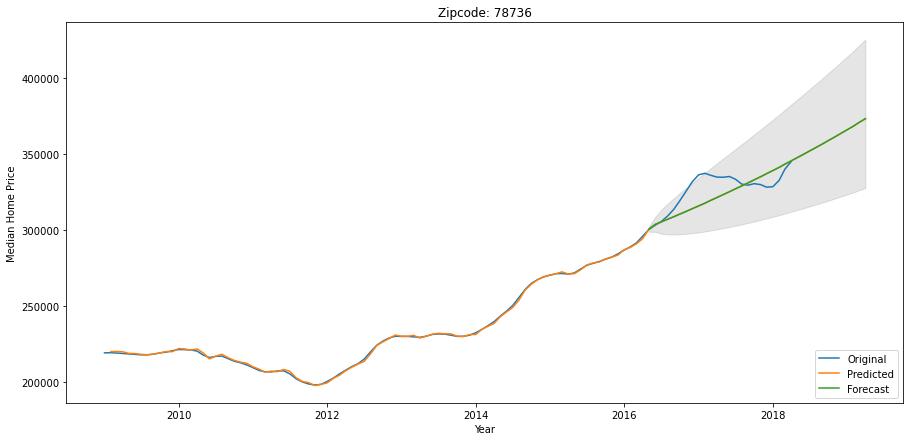

Zipcode: 78736
Explained Variance:
	 0.9896651522391893
MAE:
	 2116.365560505448
RMSE:
	 4723.266566635718
r^2:
	 0.9892604716195046
Expected ROI for 78736: 0.08162446831945583


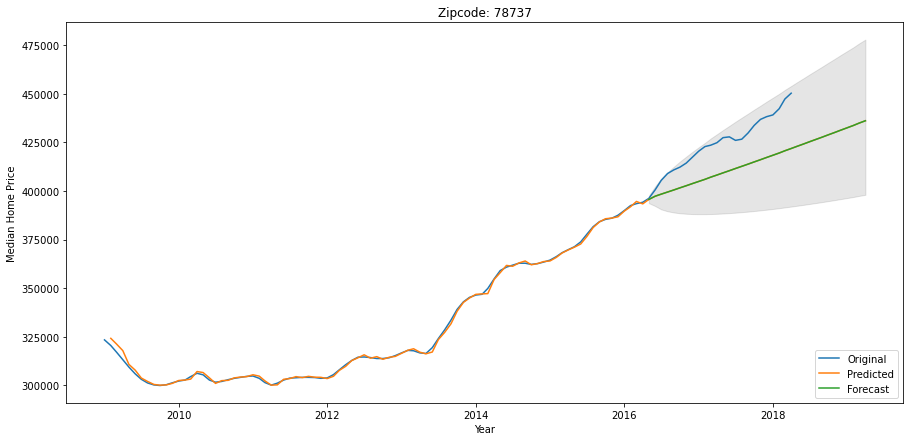

Zipcode: 78737
Explained Variance:
	 0.9776990621304261
MAE:
	 3908.185753329456
RMSE:
	 7868.5766718582645
r^2:
	 0.97302021009588
Expected ROI for 78737: -0.03151709868478685


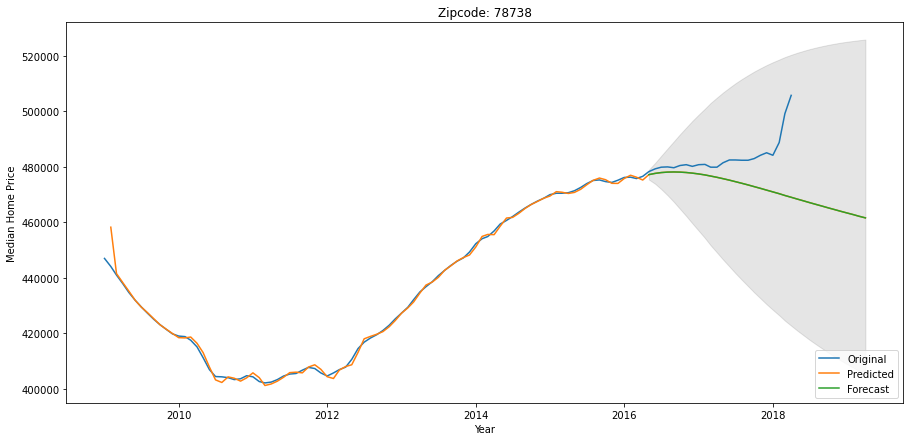

Zipcode: 78738
Explained Variance:
	 0.9666872676683278
MAE:
	 2424.4922289577707
RMSE:
	 5847.871258817419
r^2:
	 0.963427428709607
Expected ROI for 78738: -0.08734492908677528


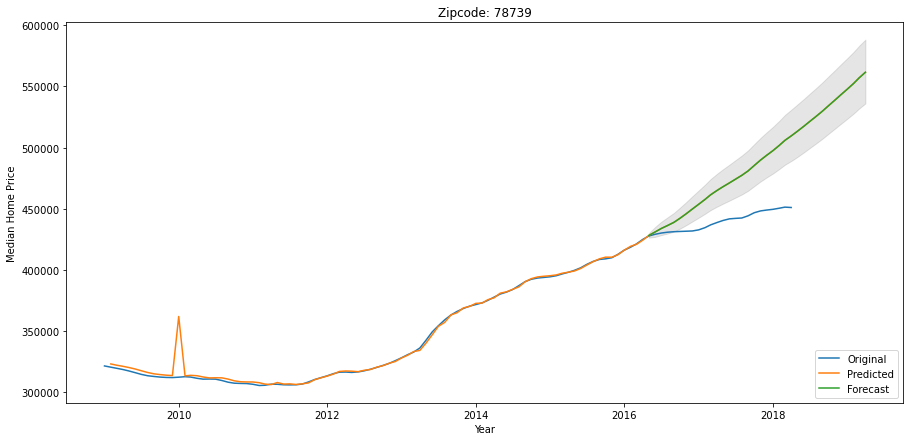

Zipcode: 78739
Explained Variance:
	 0.9267124805406264
MAE:
	 7124.934319979073
RMSE:
	 15712.192987443143
r^2:
	 0.9099432481950296
Expected ROI for 78739: 0.24530640738419265


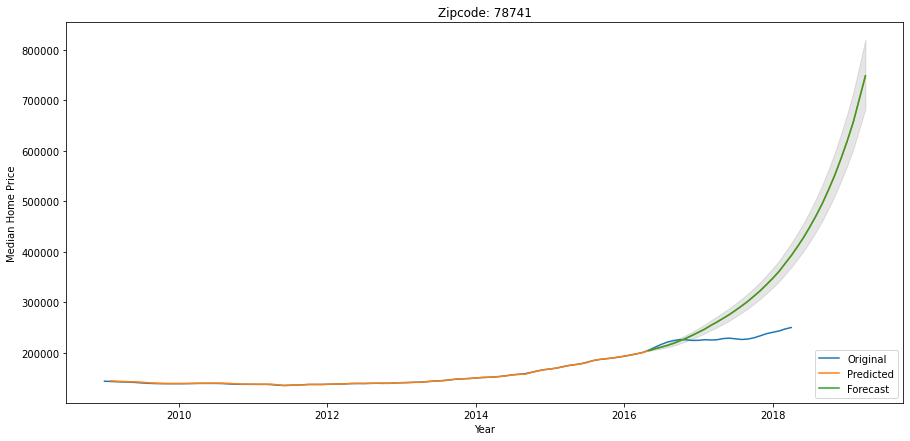

Zipcode: 78741
Explained Variance:
	 0.34367087220130166
MAE:
	 11016.548584378614
RMSE:
	 31002.17147376745
r^2:
	 0.25960045215713345
Expected ROI for 78741: 1.989546862275087


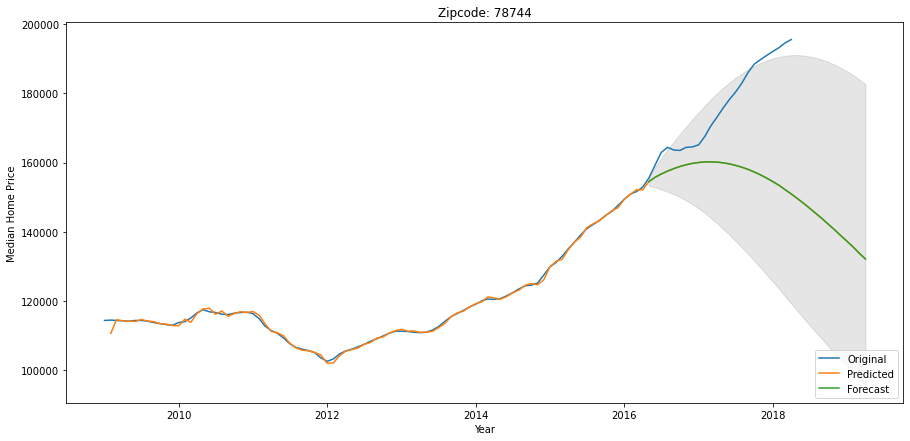

Zipcode: 78744
Explained Variance:
	 0.8563772901794833
MAE:
	 4306.174578035501
RMSE:
	 10863.20320026526
r^2:
	 0.8329622936996768
Expected ROI for 78744: -0.32399143258432156


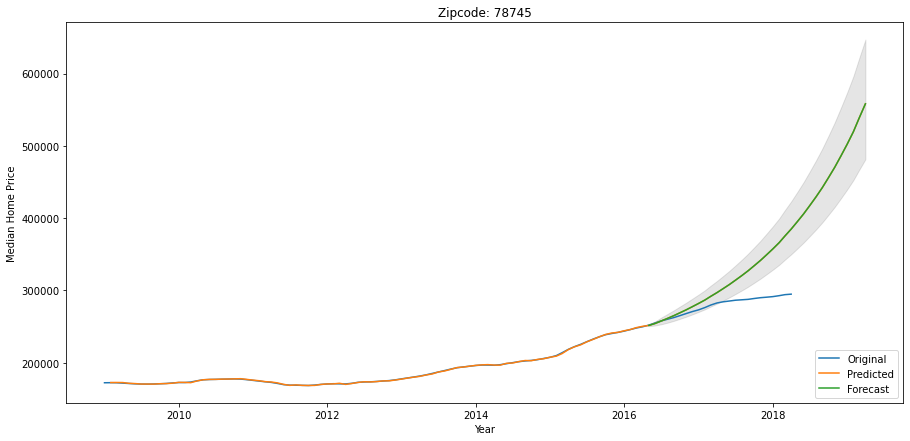

Zipcode: 78745
Explained Variance:
	 0.8326373786242651
MAE:
	 6321.332832936084
RMSE:
	 18387.8449508503
r^2:
	 0.8122521581832522
Expected ROI for 78745: 0.893672648239395


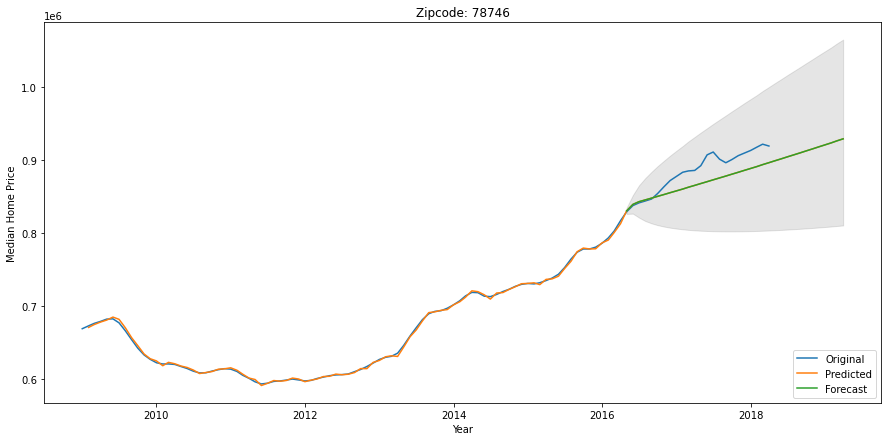

Zipcode: 78746
Explained Variance:
	 0.9924690696084062
MAE:
	 5102.490253094705
RMSE:
	 9964.663968708144
r^2:
	 0.9911663397054857
Expected ROI for 78746: 0.010680070786624356


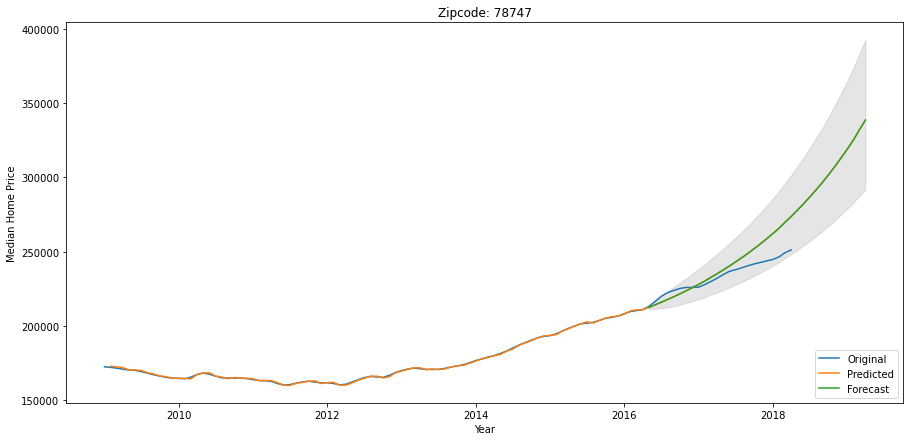

Zipcode: 78747
Explained Variance:
	 0.9738645321219349
MAE:
	 1853.058928227212
RMSE:
	 4623.195422095516
r^2:
	 0.9719361239210454
Expected ROI for 78747: 0.3478590053966956


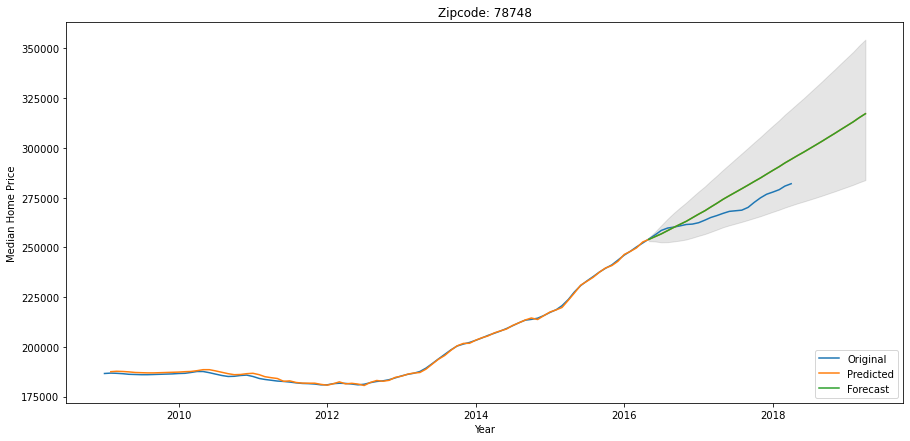

Zipcode: 78748
Explained Variance:
	 0.9905892099657501
MAE:
	 1800.5597173745452
RMSE:
	 3625.639781432146
r^2:
	 0.9884835116545135
Expected ROI for 78748: 0.12475671903952293


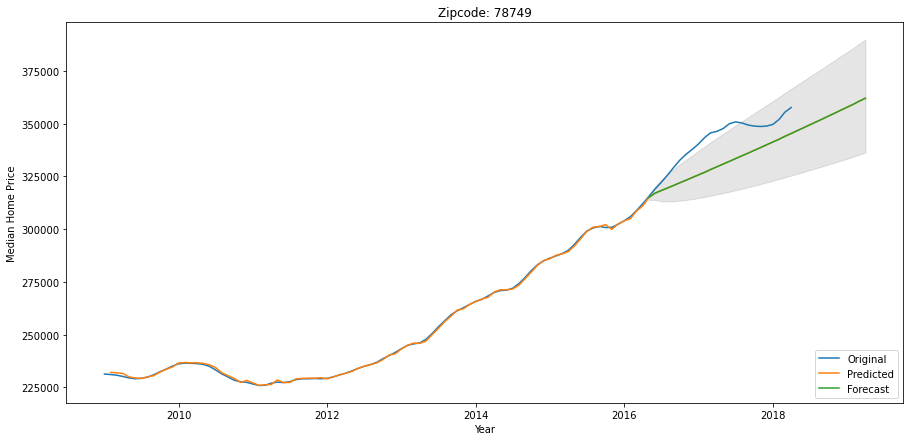

Zipcode: 78749
Explained Variance:
	 0.9857041636814801
MAE:
	 2810.629578483725
RMSE:
	 5817.529586692427
r^2:
	 0.9825487890766847
Expected ROI for 78749: 0.012329239051350886


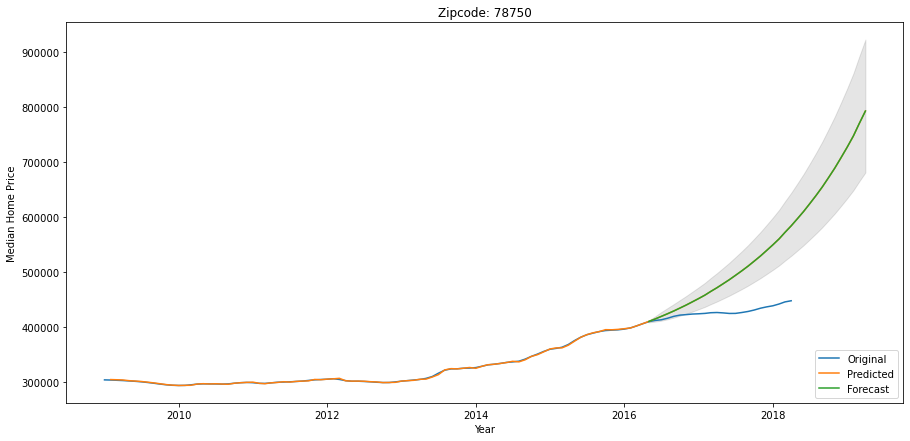

Zipcode: 78750
Explained Variance:
	 0.6631566357279303
MAE:
	 12486.092132535015
RMSE:
	 32628.670869241952
r^2:
	 0.6094133908856029
Expected ROI for 78750: 0.7678256345554675


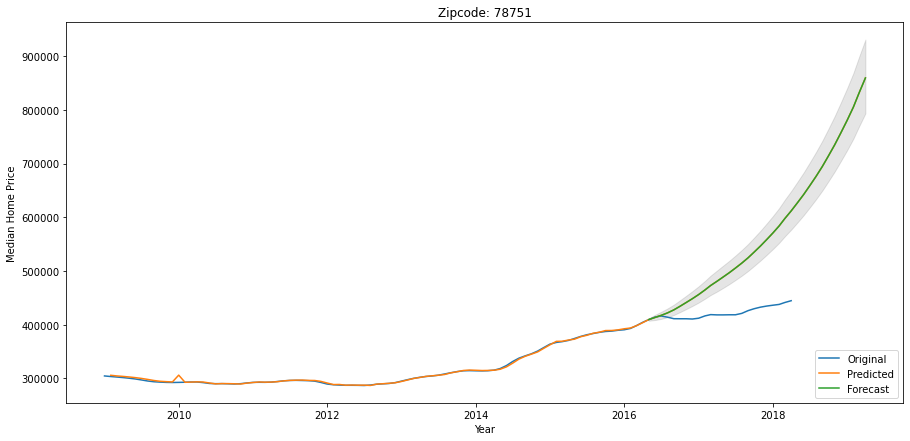

Zipcode: 78751
Explained Variance:
	 0.5107302480422948
MAE:
	 16158.254967072946
RMSE:
	 40610.58571461355
r^2:
	 0.4247662679049814
Expected ROI for 78751: 0.9331906298423231


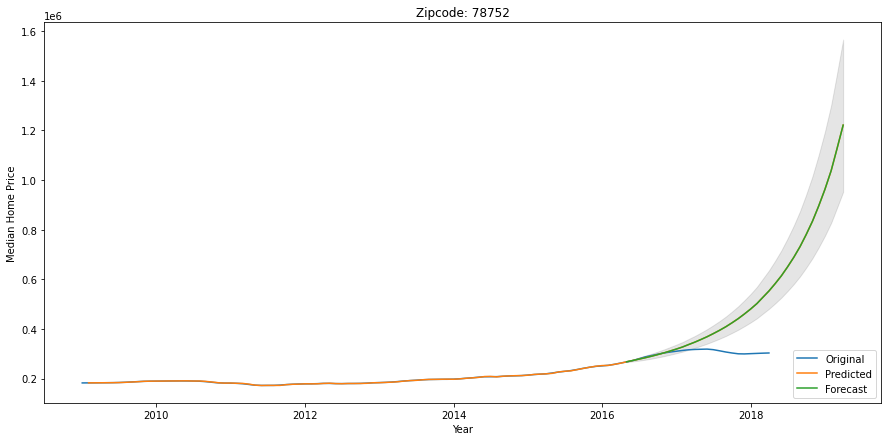

Zipcode: 78752
Explained Variance:
	 0.026277507437870495
MAE:
	 15649.997734998984
RMSE:
	 49584.111724666305
r^2:
	 -0.0744372232635675
Expected ROI for 78752: 3.0297341324730014


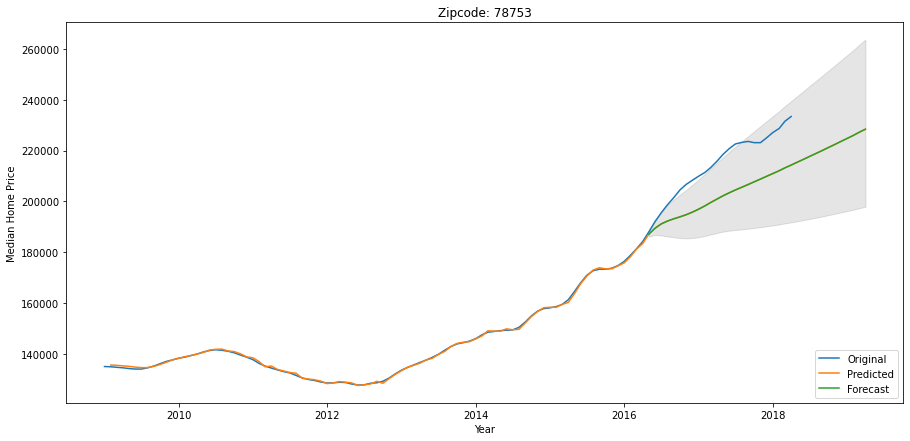

Zipcode: 78753
Explained Variance:
	 0.9668053182630888
MAE:
	 3088.307962984777
RMSE:
	 6524.824451796157
r^2:
	 0.9593095864415082
Expected ROI for 78753: -0.021398637653946593


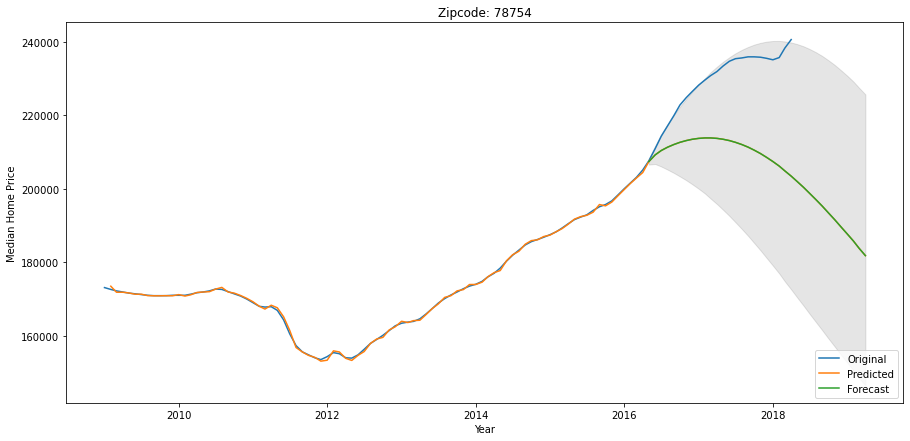

Zipcode: 78754
Explained Variance:
	 0.885539868391898
MAE:
	 4156.733009441565
RMSE:
	 9656.092239472748
r^2:
	 0.8623105077241939
Expected ROI for 78754: -0.24440328763083868


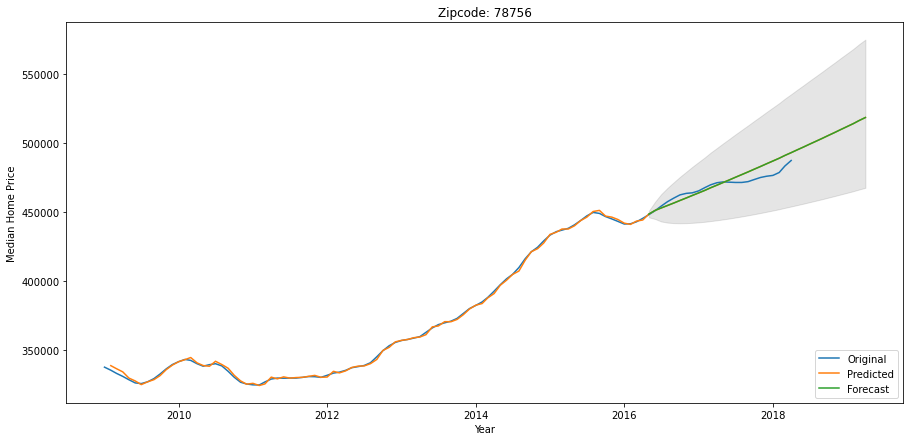

Zipcode: 78756
Explained Variance:
	 0.9978686126850304
MAE:
	 1594.8388908650252
RMSE:
	 2658.593285875239
r^2:
	 0.9977788172858107
Expected ROI for 78756: 0.06381020142265065


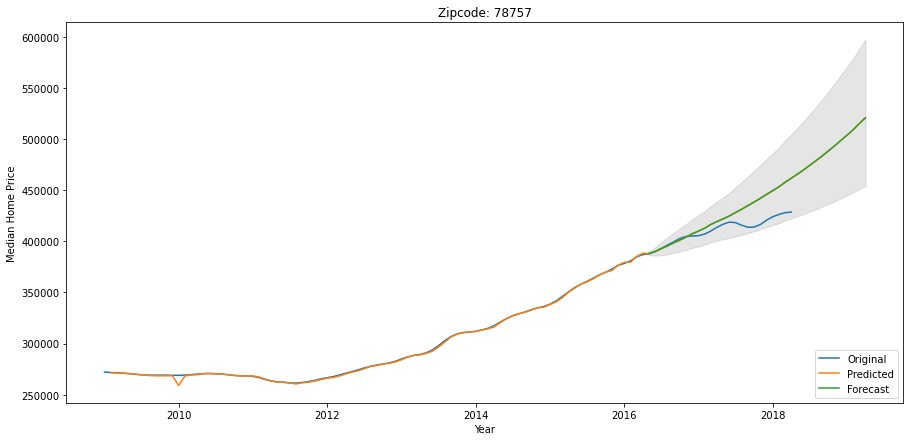

Zipcode: 78757
Explained Variance:
	 0.9837939686206985
MAE:
	 2982.6829337706263
RMSE:
	 7579.936111867399
r^2:
	 0.9824686759541454
Expected ROI for 78757: 0.21517005616754087


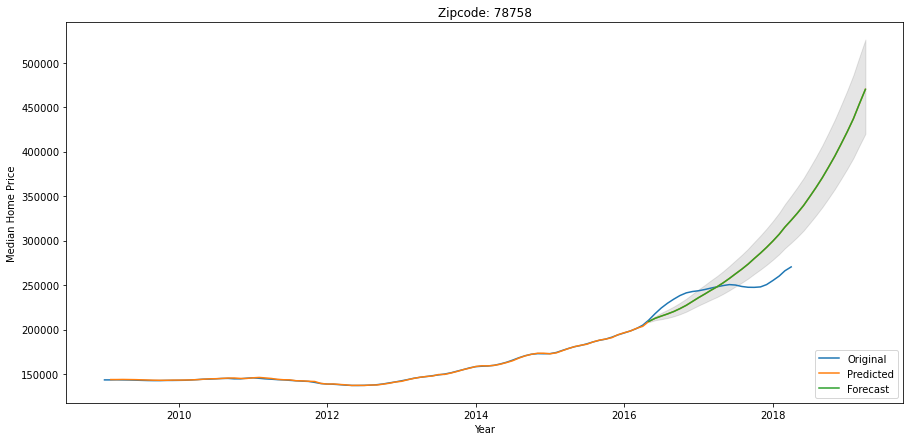

Zipcode: 78758
Explained Variance:
	 0.9176253356985964
MAE:
	 4482.78444557894
RMSE:
	 11980.152734074394
r^2:
	 0.9136908501664411
Expected ROI for 78758: 0.7379732659328976


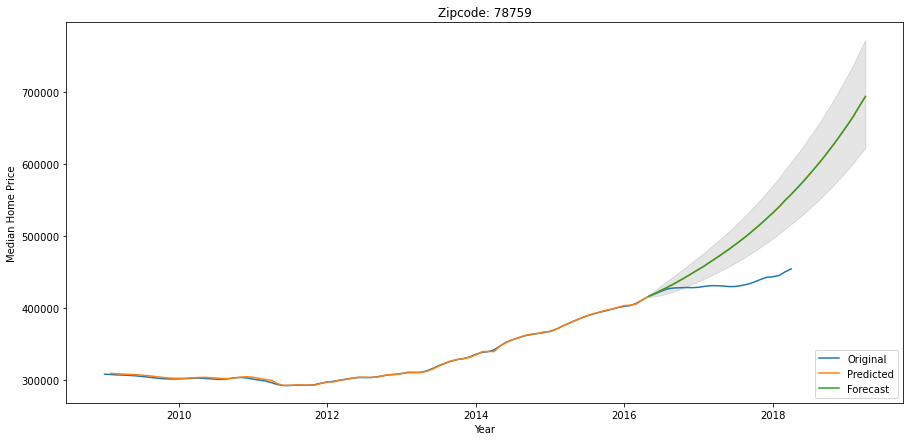

Zipcode: 78759
Explained Variance:
	 0.7953271107890485
MAE:
	 10428.20303528909
RMSE:
	 26467.324228507583
r^2:
	 0.7599696587051974
Expected ROI for 78759: 0.5286575879138137


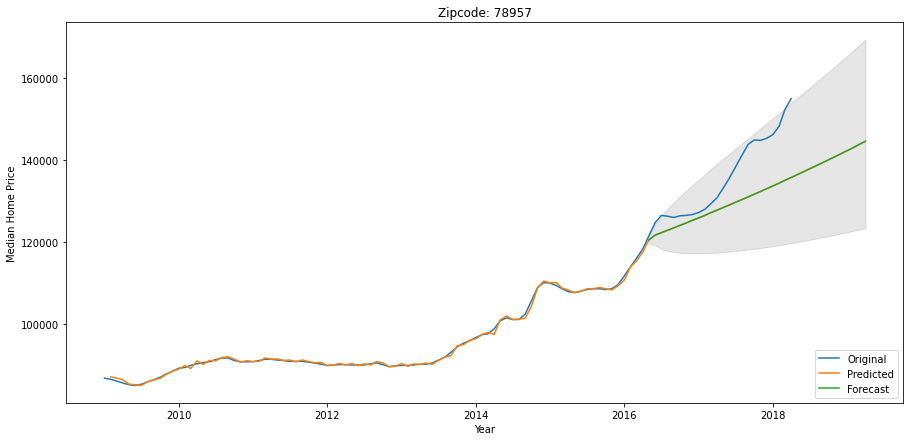

Zipcode: 78957
Explained Variance:
	 0.9549819319366563
MAE:
	 1786.888188348086
RMSE:
	 4254.014489441386
r^2:
	 0.9482033419872122
Expected ROI for 78957: -0.06719164475699924


In [34]:
cutoff = '2016-04-01'

# create a dictionary for explained variance for zipcode
var_dict = {}
# create expected ROI dictionary for each zipcode 1 year into the future
expected_ROI = {}

# run grid search ARIMA for all the zipcodes:
for zipcode in df_final.columns:
    # Train-test split
    train = df_final[zipcode][:cutoff]
    test = df_final[zipcode][cutoff:]
    
    # run grid search ARIMA
    original_series, prediction_series, forecast = run_arima_model(train, 0, 123)
    
    # plot the graph 
    fig, ax = plt.subplots(figsize=(15, 7))
    plt.plot(df_final[zipcode])
    plt.plot(prediction_series[1:])
    plt.plot(forecast['mean'])
    ax.fill_between(forecast.index, forecast['mean_ci_lower'], forecast['mean_ci_upper'], color='k', alpha=0.1);
    plt.title(f'Zipcode: {zipcode}')
    plt.legend(['Original','Predicted', 'Forecast'], loc='lower right')
    plt.xlabel('Year')
    plt.ylabel('Median Home Price')
    plt.show()
    
    # report modeling metrics:
    print(f'Zipcode: {zipcode}')
    report_metrics(df_final[zipcode][1:], prediction_series[1:-12]) 
    
    # store explained variance in the dictionary:
    var_dict[zipcode] = metrics.explained_variance_score(df_final[zipcode][1:], prediction_series[1:-12])
    
    # calculate expected return 1-year into the future:
    expected_ROI[zipcode] = (forecast['mean'][-1] - df_final[zipcode][-1])/df_final[zipcode][-1]
    # 
    print(f'Expected ROI for {zipcode}: {expected_ROI[zipcode]}')
    

## 7. Interpreting Results


In [35]:
var_dict

{76530: 0.909162232267951,
 76574: 0.9194801886838533,
 78602: 0.25091503949421345,
 78610: 0.8878648178483416,
 78612: 0.738420557541072,
 78613: 0.9915310447429279,
 78616: 0.968871596928736,
 78617: 0.9407262043096282,
 78619: 0.947697354049903,
 78620: 0.9957180766469141,
 78621: 0.8892992738933012,
 78626: 0.9949889421653906,
 78628: 0.7661811192456791,
 78633: 0.995183446371585,
 78634: 0.9966736969174443,
 78640: 0.8649534440877593,
 78641: 0.849460503780418,
 78642: 0.9621235800590056,
 78644: 0.9896140865752799,
 78645: 0.9624437179311781,
 78648: 0.9871729283437176,
 78652: 0.9897942347914457,
 78653: 0.9961392029507878,
 78655: 0.8452840691965622,
 78659: -2.5084125637767416,
 78660: 0.7793406678968033,
 78664: 0.8573243383420315,
 78665: 0.5677902794655894,
 78666: 0.7927427532688085,
 78669: 0.8627731370212457,
 78676: 0.9451414823205969,
 78681: 0.935291467752444,
 78702: 0.9240704906794809,
 78703: 0.993163273300808,
 78704: 0.9873744274194257,
 78705: 0.9179854727842124

In [36]:
# Choose zipcodes which have 99% explained varriance: 
top_zipcodes = []
for (key, value) in var_dict.items():
    if value > 0.99:
        top_zipcodes.append(key)

top_zipcodes

[78613,
 78620,
 78626,
 78633,
 78634,
 78653,
 78703,
 78723,
 78729,
 78732,
 78746,
 78748,
 78756]

In [37]:
# Print out the expected ROI of the investment suggestions:
for i in top_zipcodes:
    print(f'{i}: Expected ROI for one-year is {round(expected_ROI[i]*100, 2)}%')

78613: Expected ROI for one-year is 2.15%
78620: Expected ROI for one-year is 12.34%
78626: Expected ROI for one-year is 7.14%
78633: Expected ROI for one-year is 5.23%
78634: Expected ROI for one-year is 9.68%
78653: Expected ROI for one-year is 6.01%
78703: Expected ROI for one-year is 3.67%
78723: Expected ROI for one-year is 3.99%
78729: Expected ROI for one-year is 6.37%
78732: Expected ROI for one-year is -4.04%
78746: Expected ROI for one-year is 1.07%
78748: Expected ROI for one-year is 12.48%
78756: Expected ROI for one-year is 6.38%


In [39]:
# Construct final recommendations df to make visualizations:
Recommendations = pd.DataFrame()
Recommendations['zipcode'] = [78748, 78620, 78634, 78626, 78756]
Recommendations['ROI'] = [12.48, 12.34, 9.68, 7.14, 6.38]

long = []
lat = []
for i in Recommendations['zipcode']:
    long.append(zcdb[i].longitude)
    lat.append(zcdb[i].latitude)

Recommendations['Longitude'] =long
Recommendations['Latitude']=lat

Recommendations

zipcode    ROI  Longitude   Latitude
0    78748  12.48  -97.82265  30.172020
1    78620  12.34  -98.10753  30.241080
2    78634   9.68  -97.54611  30.540874
3    78626   7.14  -97.64713  30.643058
4    78756   6.38  -97.74177  30.320206

In [40]:
# Median house price for the suggested investment zip codes:
fig = px.line(df_final[Recommendations['zipcode']], title='Median House Prices')
fig.show()

In [41]:
# Explore relationship between expected_ROI and location
fig = px.scatter_mapbox(data_frame = Recommendations, # df name
                        lat='Latitude', # name of latitude column
                        lon='Longitude', # name of longitude column
                        zoom=8.5,
                        color='ROI',
                        size='ROI')

fig.update_layout(mapbox_style="open-street-map")
fig.show()

## 8. Conclusions & Next Steps

